In [1]:
# imports
import numpy as np
import pandas as pd
import requests
import logging
import pickle

# finance
import yfinance as yf
import pandas_datareader as pdr
import talib as ta

# visualisation
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# time
import time
from datetime import date, datetime, timedelta 

# machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from collections import Counter
import xgboost as xgb
import shap

# 0. Getting Data

In [37]:
# downloading crypto from binance
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # list of coins
        coins = [
             #biggest coins
            "BTCUSDT",
            "ETHUSDT",
            "XRPUSDT",
            "BNBUSDT",
            "SOLUSDT",
            "DOGEUSDT",
            "ADAUSDT",
            "TRXUSDT",
            "MKRUSDT",
            "AAVEUSDT",
            #stablecoin
            "USDCUSDT", 
            "TUSDUSDT",
            "FDUSDUSDT",
            "EURUSDT",
            "EURUSDC"
        ]

        def fetch_crypto_ohlc(coin, interval="1h"):
            url = "https://api.binance.com/api/v1/klines"
        
            # 90 days back from today as it is max for binance api
            start_time = datetime.now() - timedelta(days=180)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=90)).timestamp() * 1000
                    ),  # fetching 90 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            stablecoins = [ "USDCUSDT", "TUSDUSDT", "FDUSDUSDT", "EURUSDT", "EURUSDC"]
            ohlc_df["ticker"] = coin
            ohlc_df["ticker_type"] = "stablecoin" if coin in stablecoins else "cryptocurrency"
            ohlc_df['ticker_type'] = ohlc_df['ticker_type'].astype('category')

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100

            # setting the timezone to Berlin
            ohlc_df["date"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df["date"] = (
                ohlc_df["date"].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
            )
            ohlc_df.set_index("date", inplace=True)

            return ohlc_df[
                [
                    "ticker",
                    "ticker_type",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):
            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.weekday.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coins:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker", "ticker_type"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('db/crypto.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()

if __name__ == "__main__":
        get_coins()

2025-02-15 09:17:49,126 - INFO - Fetching data for BTCUSDT
2025-02-15 09:17:49,562 - INFO - Fetched data for BTCUSDT up to 2024-09-09 03:00:00.001000
2025-02-15 09:17:50,586 - INFO - Fetched data for BTCUSDT up to 2024-09-29 23:00:00.001000
2025-02-15 09:17:51,508 - INFO - Fetched data for BTCUSDT up to 2024-10-20 19:00:00.001000
2025-02-15 09:17:52,429 - INFO - Fetched data for BTCUSDT up to 2024-11-10 15:00:00.001000
2025-02-15 09:17:53,262 - INFO - Fetched data for BTCUSDT up to 2024-12-01 11:00:00.001000
2025-02-15 09:17:54,090 - INFO - Fetched data for BTCUSDT up to 2024-12-22 07:00:00.001000
2025-02-15 09:17:54,922 - INFO - Fetched data for BTCUSDT up to 2025-01-12 03:00:00.001000
2025-02-15 09:17:55,808 - INFO - Fetched data for BTCUSDT up to 2025-02-01 23:00:00.001000
2025-02-15 09:17:56,730 - INFO - Fetched data for BTCUSDT up to 2025-02-15 08:00:00.001000
2025-02-15 09:17:57,543 - WARNING - No OHLC data found for BTCUSDT.
2025-02-15 09:17:57,569 - INFO - Fetching data for ETH

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64815 entries, 2024-08-19 10:00:00+02:00 to 2025-02-15 09:00:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          64815 non-null  int64   
 1   month         64815 non-null  int64   
 2   day           64815 non-null  int64   
 3   hour          64815 non-null  int64   
 4   ticker        64815 non-null  category
 5   ticker_type   64815 non-null  object  
 6   open          64815 non-null  float64 
 7   high          64815 non-null  float64 
 8   low           64815 non-null  float64 
 9   close         64815 non-null  float64 
 10  price_change  64815 non-null  float64 
 11  volume        64815 non-null  float64 
dtypes: category(1), float64(6), int64(4), object(1)
memory usage: 6.0+ MB


In [39]:
#crpypto2
# downloading crypto from Kraken

def get_coins():
    # set up logging to display info and error messages
    logging.basicConfig(
        level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
    )

    # dai
    coins = [
        "DAIUSD",
        "DAIEUR"
    ]

    def fetch_crypto_ohlc(coin, interval=60):  
        url = f"https://api.kraken.com/0/public/OHLC"
        
        # 90 days back from today as the range for Kraken API
        start_time = int((datetime.now() - timedelta(days=180)).timestamp())

        # Kraken parameters
        params = {
            "pair": coin,
            "interval": interval, 
            "since": start_time,
        }

        response = requests.get(url, params=params)

        # check if request was successful
        if response.status_code != 200:
            logging.error(f"Error fetching data for {coin}: {response.status_code}")
            return pd.DataFrame()

        data = response.json()
        if "error" in data and data["error"]:
            logging.error(f"Error in Kraken API response for {coin}: {data['error']}")
            return pd.DataFrame()

        # Extract OHLC data
        ohlc_data = data["result"].get(coin)
        if not ohlc_data:
            logging.warning(f"No OHLC data found for {coin}.")
            return pd.DataFrame()

        # Convert to DataFrame
        ohlc_df = pd.DataFrame(
            ohlc_data,
            columns=[
                "timestamp", "open", "high", "low", "close", "vwap", "volume", "count"
            ],
        )

        stablecoins = ["DAIUSD", "DAIEUR"]
        ohlc_df["ticker"] = coin
        ohlc_df["ticker_type"] = (
            "stablecoin" if coin in stablecoins else "cryptocurrency"
        )
        ohlc_df['ticker_type'] = ohlc_df['ticker_type'].astype('category')

        # convert price and volume to float
        ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[
            ["open", "high", "low", "close", "volume"]
        ].astype(float)
        ohlc_df["price_change"] = (
            (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100
        )

        # setting the timezone to Berlin
        ohlc_df["date"] = pd.to_datetime(ohlc_df["timestamp"], unit="s")
        ohlc_df["date"] = (
            ohlc_df["date"].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
        )
        ohlc_df.set_index("date", inplace=True)

        return ohlc_df[
            [
                "ticker",
                "ticker_type",
                "open",
                "high",
                "low",
                "close",
                "price_change",
                "volume",
            ]
        ]

    def generate_datetime_features(df):
        # generate additional datetime features
        df["year"] = df.index.year.astype(int)
        df["month"] = df.index.month.astype(int)
        df["day"] = df.index.weekday.astype(int)
        df["hour"] = df.index.hour.astype(int)

        return df

    # main script
    all_data = pd.DataFrame()

    for coin in coins:
        logging.info(f"Fetching data for {coin}")
        df = fetch_crypto_ohlc(coin)

        if not df.empty:
            df = generate_datetime_features(df)
            all_data = pd.concat([all_data, df])
        else:
            logging.warning(f"No data fetched for {coin}")

    # reorder columns to have datetime features at the beginning
    datetime_features = ["year", "month", "day", "hour", "ticker", "ticker_type"]
    other_columns = [col for col in all_data.columns if col not in datetime_features]
    all_data = all_data[datetime_features + other_columns]

    all_data['ticker'] = all_data['ticker'].astype('category')

    # save df to csv
    all_data.to_csv('db/crypto_kraken.csv', index=True)
    logging.info("Data fetching and processing complete. Data saved to crypto_kraken.csv")

    all_data.info()

    all_data.describe()

if __name__ == "__main__":
    get_coins()


2025-02-15 09:22:21,252 - INFO - Fetching data for DAIUSD
2025-02-15 09:22:21,460 - INFO - Fetching data for DAIEUR
2025-02-15 09:22:21,684 - INFO - Data fetching and processing complete. Data saved to crypto_kraken.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2025-01-16 10:00:00+01:00 to 2025-02-15 09:00:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          1440 non-null   int64   
 1   month         1440 non-null   int64   
 2   day           1440 non-null   int64   
 3   hour          1440 non-null   int64   
 4   ticker        1440 non-null   category
 5   ticker_type   1440 non-null   category
 6   open          1440 non-null   float64 
 7   high          1440 non-null   float64 
 8   low           1440 non-null   float64 
 9   close         1440 non-null   float64 
 10  price_change  1440 non-null   float64 
 11  volume        1440 non-null   float64 
dtypes: category(2), float64(6), int64(4)
memory usage: 126.8 KB


In [2]:
# combining them into one df
crypto_df = pd.read_csv('db/crypto.csv')
crypto_kraken = pd.read_csv('db/crypto_kraken.csv')

# concat
df = pd.concat([crypto_df, crypto_kraken], ignore_index=True)

# transform object to category
df['ticker'] = df['ticker'].astype('category')
df['ticker_type'] = df['ticker_type'].astype('category')

df.head(3)

,date,year,month,day,hour,ticker,ticker_type,open,high,low,close,price_change,volume
0,2024-08-19 10:00:00+02:00,2024,8,0,10,BTCUSDT,cryptocurrency,58502.19,58660.85,58403.16,58608.27,0.181327,555.99622
1,2024-08-19 11:00:00+02:00,2024,8,0,11,BTCUSDT,cryptocurrency,58608.28,58671.38,57965.60,58006.59,-1.026630,1680.68671
2,2024-08-19 12:00:00+02:00,2024,8,0,12,BTCUSDT,cryptocurrency,58006.60,58199.28,57787.30,58046.01,0.067941,1538.43823


In [3]:
df.dtypes

date              object
year               int64
month              int64
day                int64
hour               int64
ticker          category
ticker_type     category
open             float64
high             float64
low              float64
close            float64
price_change     float64
volume           float64
dtype: object

In [4]:
print(df.shape)

(66255, 13)


# 1. Feature Engeneering

In [5]:
# creating new columns

# moving averages
df['7d_ma'] = df['close'].rolling(window=7).mean().shift(1)
df['30d_ma'] = df['close'].rolling(window=30).mean().shift(1)

# volatility (standard deviation of 'close' over last 7 days)
df['7d_volatility'] = df['close'].rolling(window=7).std().shift(1)

# relative intraday range
df['intraday_range'] = ((df['high'] - df['low']) / df['low']).shift(1)

# simple moving average 10 days and 20 days
df['sma10'] = df['close'].rolling(10).mean().shift(1)
df['sma20'] = df['close'].rolling(20).mean().shift(1)

# volume change
df['volume_change'] = df['volume'].pct_change().shift(1)
# replace infinity with NaN
df['volume_change'] = df['volume_change'].replace([np.inf, -np.inf], np.nan)


# lag features
df['close_lag_1'] = df['close'].shift(1)

# talib
def add_ta_indicators(df):
    # ensure columns have correct data types
    df["open"] = df["open"].astype("float64")
    df["high"] = df["high"].astype("float64")
    df["low"] = df["low"].astype("float64")
    df["close"] = df["close"].astype("float64")
    df["volume"] = df["volume"].astype("float64")

    # calculate various technical indicators using TA-Lib
    high_shift = df['high'].shift(1)
    low_shift = df['low'].shift(1)
    close_shift = df['close'].shift(1)
    open_shift = df['open'].shift(1)
    volume_shift = df['volume'].shift(1)
    
    # Calculate various technical indicators using TA-Lib with shifted data
    df['adx'] = ta.ADX(high_shift, low_shift, close_shift)
    df['aroon'] = ta.AROON(high_shift, low_shift)[0] 
    df['bop'] = ta.BOP(open_shift, high_shift, low_shift, close_shift)
    df['cci'] = ta.CCI(high_shift, low_shift, close_shift)
    df['cmo'] = ta.CMO(close_shift)
    df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(close_shift)
    df['mom'] = ta.MOM(close_shift)
    df['ppo'] = ta.PPO(close_shift)
    df['roc'] = ta.ROC(close_shift)
    df['rsi'] = ta.RSI(close_shift)
    df['willr'] = ta.WILLR(high_shift, low_shift, close_shift)
    df['atr'] = ta.ATR(high_shift, low_shift, close_shift)
    df['trix'] = ta.TRIX(close_shift)
    df['kama'] = ta.KAMA(close_shift)
    return df

    return df

df = add_ta_indicators(df)


# custom calculations
# calculating future growth
def add_custom_calculations(df, group_by_col="ticker"):
    # growth calculations for different time periods
    for hours in [1, 4, 24, 72]:
        df[f"growth_{hours}h"] = (
            df["close"].shift(1) / df.groupby(group_by_col, observed=True)["close"].shift(hours+1)
        )
            

    # fibonacci levels
    df["fibonacci_0"] = df["close"].shift(1) 
    df["fibonacci_23_6"] = df["high"].shift(1) - (df["high"].shift(1) - df["low"].shift(1)) * 0.236
    df["fibonacci_38_2"] = df["high"].shift(1) - (df["high"].shift(1) - df["low"].shift(1)) * 0.382
    df["fibonacci_50"] = df["high"].shift(1) - (df["high"].shift(1) - df["low"].shift(1)) * 0.5
    df["fibonacci_61_8"] = df["high"].shift(1) - (df["high"].shift(1) - df["low"].shift(1)) * 0.618
    df["fibonacci_100"] = df["low"].shift(1)  

    return df

df = add_custom_calculations(df)

In [6]:
# Apply a logarithmic transformation to the 'Volume' column to reduce skewness and deal with potential outliers.
# We add 1 to avoid taking the log of 0 (which is undefined).
# Then, drop the original 'Volume' column, as we will only use the transformed 'ln_volume' for modeling.
df['ln_volume'] = df.volume.apply(lambda x: np.log(x + 1))
df.drop(columns=['volume'], inplace=True)


In [7]:
df.tail(5)

,date,year,month,day,hour,ticker,ticker_type,open,high,low,...,growth_4h,growth_24h,growth_72h,fibonacci_0,fibonacci_23_6,fibonacci_38_2,fibonacci_50,fibonacci_61_8,fibonacci_100,ln_volume
66250,2025-02-15 05:00:00+01:00,2025,2,5,5,DAIEUR,stablecoin,0.95393,0.95393,0.95393,...,1.000000,0.996272,0.987996,0.95393,0.953930,0.953930,0.95393,0.953930,0.95393,0.000000
66251,2025-02-15 06:00:00+01:00,2025,2,5,6,DAIEUR,stablecoin,0.95372,0.95372,0.95372,...,1.000000,0.996272,0.987996,0.95393,0.953930,0.953930,0.95393,0.953930,0.95393,2.440973
66252,2025-02-15 07:00:00+01:00,2025,2,5,7,DAIEUR,stablecoin,0.95372,0.95372,0.95334,...,0.999780,0.996052,0.987779,0.95372,0.953720,0.953720,0.95372,0.953720,0.95372,8.484707
66253,2025-02-15 08:00:00+01:00,2025,2,5,8,DAIEUR,stablecoin,0.95350,0.95373,0.95349,...,0.999382,0.995655,0.986731,0.95334,0.953630,0.953575,0.95353,0.953485,0.95334,6.871876
66254,2025-02-15 09:00:00+01:00,2025,2,5,9,DAIEUR,stablecoin,0.95371,0.95371,0.95371,...,0.999790,0.996167,0.987135,0.95373,0.953673,0.953638,0.95361,0.953582,0.95349,2.055573


In [8]:
# new csv
df.to_csv('db/one_df.csv', index=False)

# 2. EDA

In [9]:
# checking for nan all rows colums
nan_counts = df.isna().sum()
print(f"NAN for ticker: {nan_counts}")

# 0 values per row
zero_counts = (df == 0).sum()
zero_columns = zero_counts[zero_counts > 0].sort_values(ascending=False).head(10)
print("Top columns with 0 values:")
print(f"0 values {zero_columns}")

# deleting rows where day is 0
df.drop(df[df['day'] == 0].index, inplace=True)

# printing datatypes
print(f"Data types: {df.dtypes}")

# getting overview of unique tickers
unique_tickers = df['ticker'].nunique()
print(f"Number of individuel ticker: {unique_tickers}")

for col in df.columns:
    print(col)
    print(df[col].nunique())
    print()

NAN for ticker: date                 0
year                 0
month                0
day                  0
hour                 0
ticker               0
ticker_type          0
open                 0
high                 0
low                  0
close                0
price_change         0
7d_ma                7
30d_ma              30
7d_volatility        7
intraday_range       1
sma10               10
sma20               20
volume_change      178
close_lag_1          1
adx                 28
aroon               15
bop                  1
cci                 14
cmo                 15
macd                34
macd_signal         34
macd_hist           34
mom                 11
ppo                 26
roc                 11
rsi                 15
willr               14
atr                 15
trix                89
kama                31
growth_1h           34
growth_4h           85
growth_24h         425
growth_72h        1241
fibonacci_0          1
fibonacci_23_6       1
fibonacci_38_2    

In [10]:
# overview stats
mkr_data = df[df['ticker'] == 'MKRUSDT']

# number of data for 'close'
n = len(mkr_data)
print(f"Number of data for MKRUSDT: {n}")

# max and price change
max_price_change = mkr_data['price_change'].max()
print("Max price change for MKRUSDT:", max_price_change)


Number of data for MKRUSDT: 3707
Max price change for MKRUSDT: 6.61764705882353


In [11]:
# overview stats
dai_data = df[df['ticker'] == 'DAIUSD']

# number of data for 'close'
n = len(dai_data)
print(f"Number of data for DAIUSD: {n}")

# max and price change
max_price_change = dai_data['price_change'].max()
print("Max price change for DAIUSD:", max_price_change)


Number of data for DAIUSD: 624
Max price change for DAIUSD: 0.1822661085184301


In [12]:
# looking at outliers dai, define thresholds for outliers
lower_threshold = 0.999
upper_threshold = 1.001

# Find outliers based on the close price
outliers = dai_data[(dai_data['close'] < lower_threshold) | (dai_data['close'] > upper_threshold)]

# Formatierte Tabelle der Outliers
outliers_formatted = outliers[['year','month', 'day', 'hour', 'close']].sort_values('close')
print("\nDetailed Outliers Information:")
print(outliers_formatted.to_string(index=False))



Detailed Outliers Information:
 year  month  day  hour   close
 2025      2    5     3 1.00101
 2025      2    4     2 1.00103
 2025      1    4    19 1.00104
 2025      1    5     8 1.00104
 2025      1    4    18 1.00106
 2025      2    4    21 1.00119
 2025      2    4     7 1.00120
 2025      2    4    10 1.00134
 2025      2    3    14 1.00135
 2025      2    4     8 1.00137
 2025      1    4    22 1.00138
 2025      2    5     2 1.00141
 2025      2    3    10 1.00144
 2025      2    6    23 1.00146
 2025      2    3    21 1.00150
 2025      2    4     9 1.00182
 2025      2    4     5 1.00192
 2025      2    4     6 1.00263


In [13]:
stats_columns = ['close', 'price_change', 'ln_volume', '7d_ma', '30d_ma', 
                 '7d_volatility', 'intraday_range', 'adx', 'rsi', 
                 'macd', 'macd_signal', 'macd_hist', 
                 'growth_1h', 'growth_4h', 'growth_72h'] 
stats_summary = mkr_data[stats_columns].describe()
print("Statistical Summary:\n", stats_summary)

Statistical Summary:
              close  price_change    ln_volume        7d_ma       30d_ma  \
count  3707.000000   3707.000000  3707.000000  3707.000000  3707.000000   
mean   1511.793094     -0.013866     5.643471  1512.778758  1511.984647   
std     309.008037      0.885456     0.920715   308.342456   306.834357   
min     880.000000     -4.351032     2.847916   892.714286   896.190743   
25%    1288.000000     -0.442880     4.996005  1289.500000  1288.572067   
50%    1509.000000      0.000000     5.596232  1510.857143  1506.833333   
75%    1668.000000      0.410221     6.244722  1668.285714  1664.700000   
max    2411.000000      6.617647     9.095620  2374.285714  2310.300000   

       7d_volatility  intraday_range          adx          rsi         macd  \
count    3707.000000     3707.000000  3707.000000  3707.000000  3707.000000   
mean       12.715868        0.012874    27.864553    48.701525     1.060670   
std        10.436298        0.008537    11.896049    11.845371   

In [14]:
# Statistical Summary Analysis:
# - 'close' price ranges from 880 to 2411, with a mean of 1511.79.
# - 'price_change' varies widely (-4.35 to 6.62), indicating volatility.
# - 'ln_volume' has a mean of 5.64, suggesting log-transformed trade volumes.
# - Moving averages ('7d_ma', '30d_ma') are closely aligned with the mean close price.
# - '7d_volatility' shows fluctuations, ranging from 1.46 to 88.32.
# - Indicators like 'adx' (avg. 27.86) and 'rsi' (avg. 48.70) reflect market trends.
# - MACD-related values ('macd', 'macd_signal', 'macd_hist') indicate trend strength.
# - Growth metrics ('growth_1h', 'growth_4h', 'growth_72h') show minor variations, 
#   suggesting relatively stable short-term price movements.


# 3. Visualisation

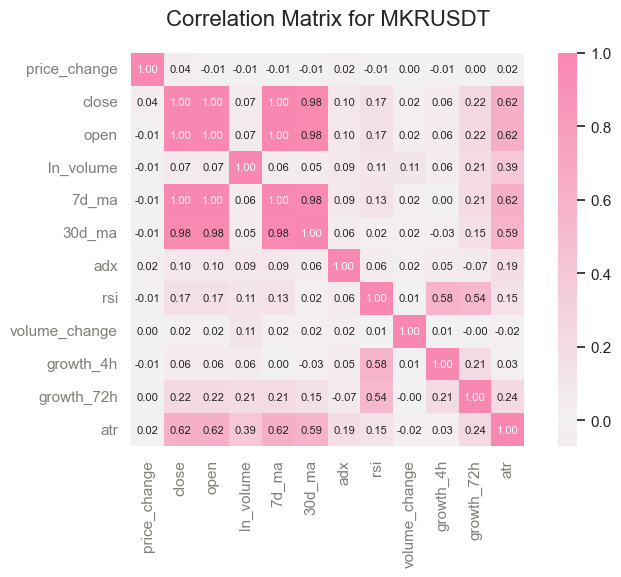

In [15]:
# correlation matrix
sns.set(style="whitegrid")
# calculation
mkr_data = df[df['ticker'] == 'MKRUSDT']
cor_columns = cor_columns = [
    'price_change', 'close', 'open', 'ln_volume', '7d_ma', '30d_ma', 'adx',
    'rsi', 'volume_change', 'growth_4h', 'growth_72h', 'atr'
]
correlation_matrix_mkr = mkr_data[cor_columns].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(
  correlation_matrix_mkr,
  annot=True,
  cmap=sns.diverging_palette(h_neg=0, h_pos=350, s=90, l=70, as_cmap=True), 
  center=0,
  fmt='.2f',
  square=True,
  annot_kws={'size': 8}
)
# style
plt.title("Correlation Matrix for MKRUSDT", fontsize=16, pad=20)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
ax = plt.gca()
# remove axis frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# colour ticks
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

plt.tight_layout()
# saving
plt.savefig("images/correlation_matrix_mkr.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Summary of the correlation matrix analysis:
# Price Change Independence: `price_change` shows minimal correlation with all other features (values between -0.01 and 0.04), indicating it's relatively independent of other market indicators.
# High Multicollinearity Group: There's extremely high correlation (≈1.0) between `close`, `open`, and `7d_ma`, suggesting redundant information that could lead to model instability.
# Medium Correlation Group: `atr` shows moderate to strong correlation (0.59-0.62) with price levels (`close`, `open`, `7d_ma`, `30d_ma`), indicating its close relationship with recent price action.
# Technical Indicator Relationships: `rsi` has notable correlation with growth metrics (`growth_4h`: 0.58, `growth_72h`: 0.54), suggesting these features capture similar market momentum patterns.
# Volume Metrics: `volume_change` shows minimal correlation with other features, making it a potentially valuable independent signal.


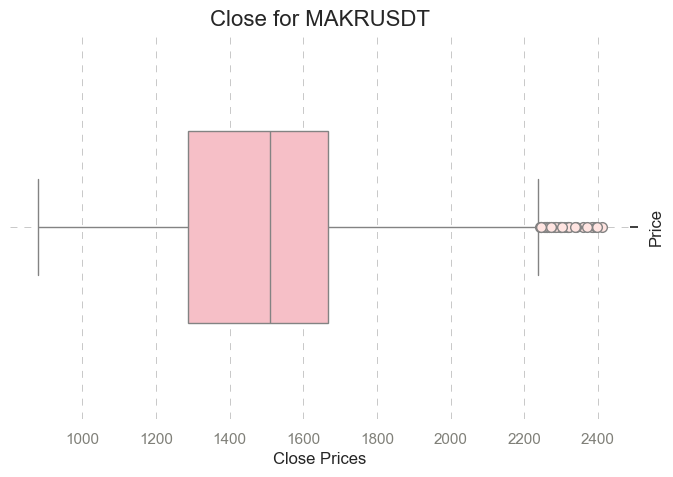

In [17]:
#boxplot
# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=mkr_data['close'],
    color='#FFB6C1',
    width=0.5,
    flierprops=dict(markerfacecolor='#FFE4E1', marker='o', markersize=7)
)

# title, axis
plt.title('Close for MAKRUSDT', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Close Prices', fontsize=12)
plt.ylabel('Price', fontsize=12)
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# remove axis frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)

# ticks colour
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# save
plt.savefig('images/boxplot_mkr.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
# quantile
q1 = mkr_data['close'].quantile(0.25)
q3 = mkr_data['close'].quantile(0.75)
q1, q3

(1288.0, 1668.0)

In [19]:
# Price Analysis for MAKRUSDT:
# - The interquartile range (IQR) spans from Q1 = 1288.0 to Q3 = 1668.0, representing the middle 50% of closing prices.
# - The median close price appears to be around the center of the IQR, indicating a relatively symmetric distribution.
# - The presence of outliers beyond the upper whisker (above ≈ 2200) suggests occasional price spikes.
# - The lower whisker extends towards ≈ 900-1000, indicating a historical lower price range.
# - This distribution suggests that while the majority of prices are within a stable range, significant upward price jumps 
#   have occurred, which could be relevant for volatility analysis.


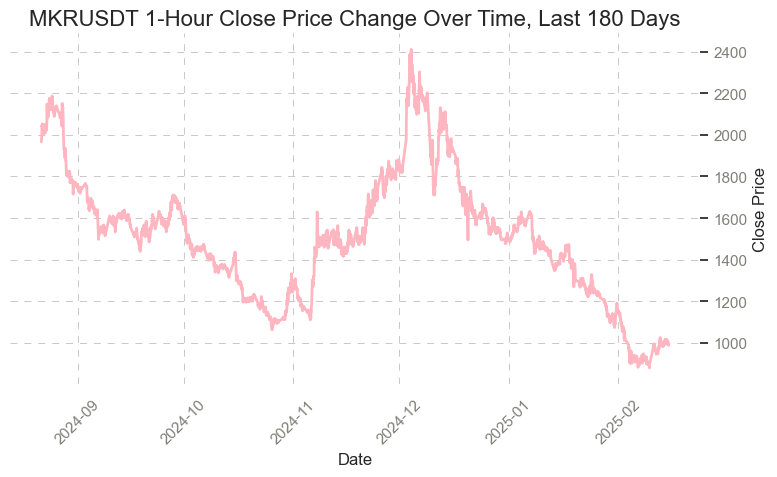

In [20]:
# Converting time
mkr_data = mkr_data.copy()
mkr_data.loc[:, 'date'] = pd.to_datetime(mkr_data['date'], utc=True).dt.tz_convert('Europe/Berlin')
start = (pd.Timestamp.now(tz='Europe/Berlin') - pd.Timedelta(days=180))
end = pd.Timestamp.now(tz='Europe/Berlin')
mkr_data_filtered = mkr_data[(mkr_data['date'] >= start) & (mkr_data['date'] <= end)]

# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# plot
plt.plot(mkr_data_filtered['date'], mkr_data_filtered['close'], color='#FFB6C1', linewidth=2)
plt.title('MKRUSDT 1-Hour Close Price Change Over Time, Last 180 Days', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticker
plt.xticks(rotation=45)
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# Saving
plt.tight_layout()
plt.savefig('images/timeseries_mkrusdt.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# MKRUSDT Price Analysis:
# Over the last 180 days, MKRUSDT exhibited high volatility.
# The price peaked in December 2024, surpassing 2400 USDT, followed by a strong decline.
# A continuous downtrend can be observed from January 2025, stabilizing around 1000 USDT in February.
# This suggests a period of strong speculative movement, followed by a bearish correction.


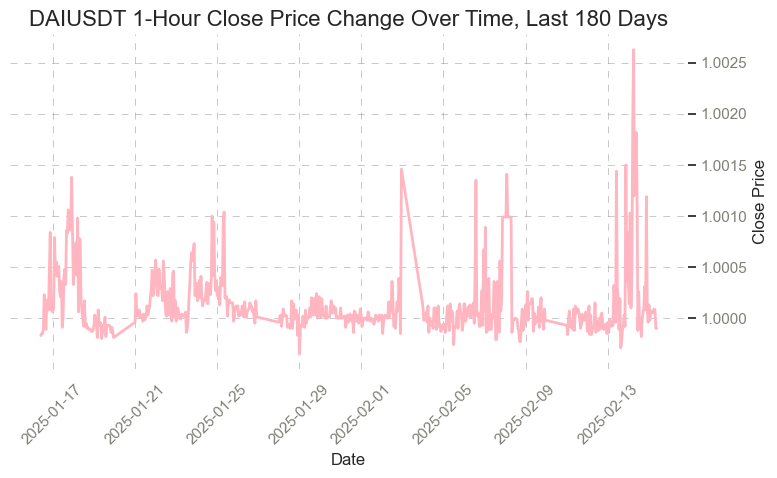

In [22]:
# Converting time
dai_data.loc[:, 'date'] = pd.to_datetime(dai_data['date'], utc=True).dt.tz_convert('Europe/Berlin')
start = (pd.Timestamp.now(tz='Europe/Berlin') - pd.Timedelta(days=180))
end = pd.Timestamp.now(tz='Europe/Berlin')
dai_data_filtered = dai_data[(dai_data['date'] >= start) & (dai_data['date'] <= end)]

# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# plot
plt.plot(dai_data_filtered['date'], dai_data_filtered['close'], color='#FFB6C1', linewidth=2)
plt.title('DAIUSDT 1-Hour Close Price Change Over Time, Last 180 Days', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticker
plt.xticks(rotation=45)
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# Saving
plt.tight_layout()
plt.savefig('images/timeseries_daiusd.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# DAIUSDT Price Analysis:
# DAIUSDT, being a stablecoin, maintained a price close to 1.0000 USDT.
# However, occasional spikes above 1.0025 USDT indicate temporary deviations from the peg.
# Increased volatility was observed in early February 2025, possibly due to liquidity shifts or market events.
# Overall, the price remained within an expected range, reinforcing its stability.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


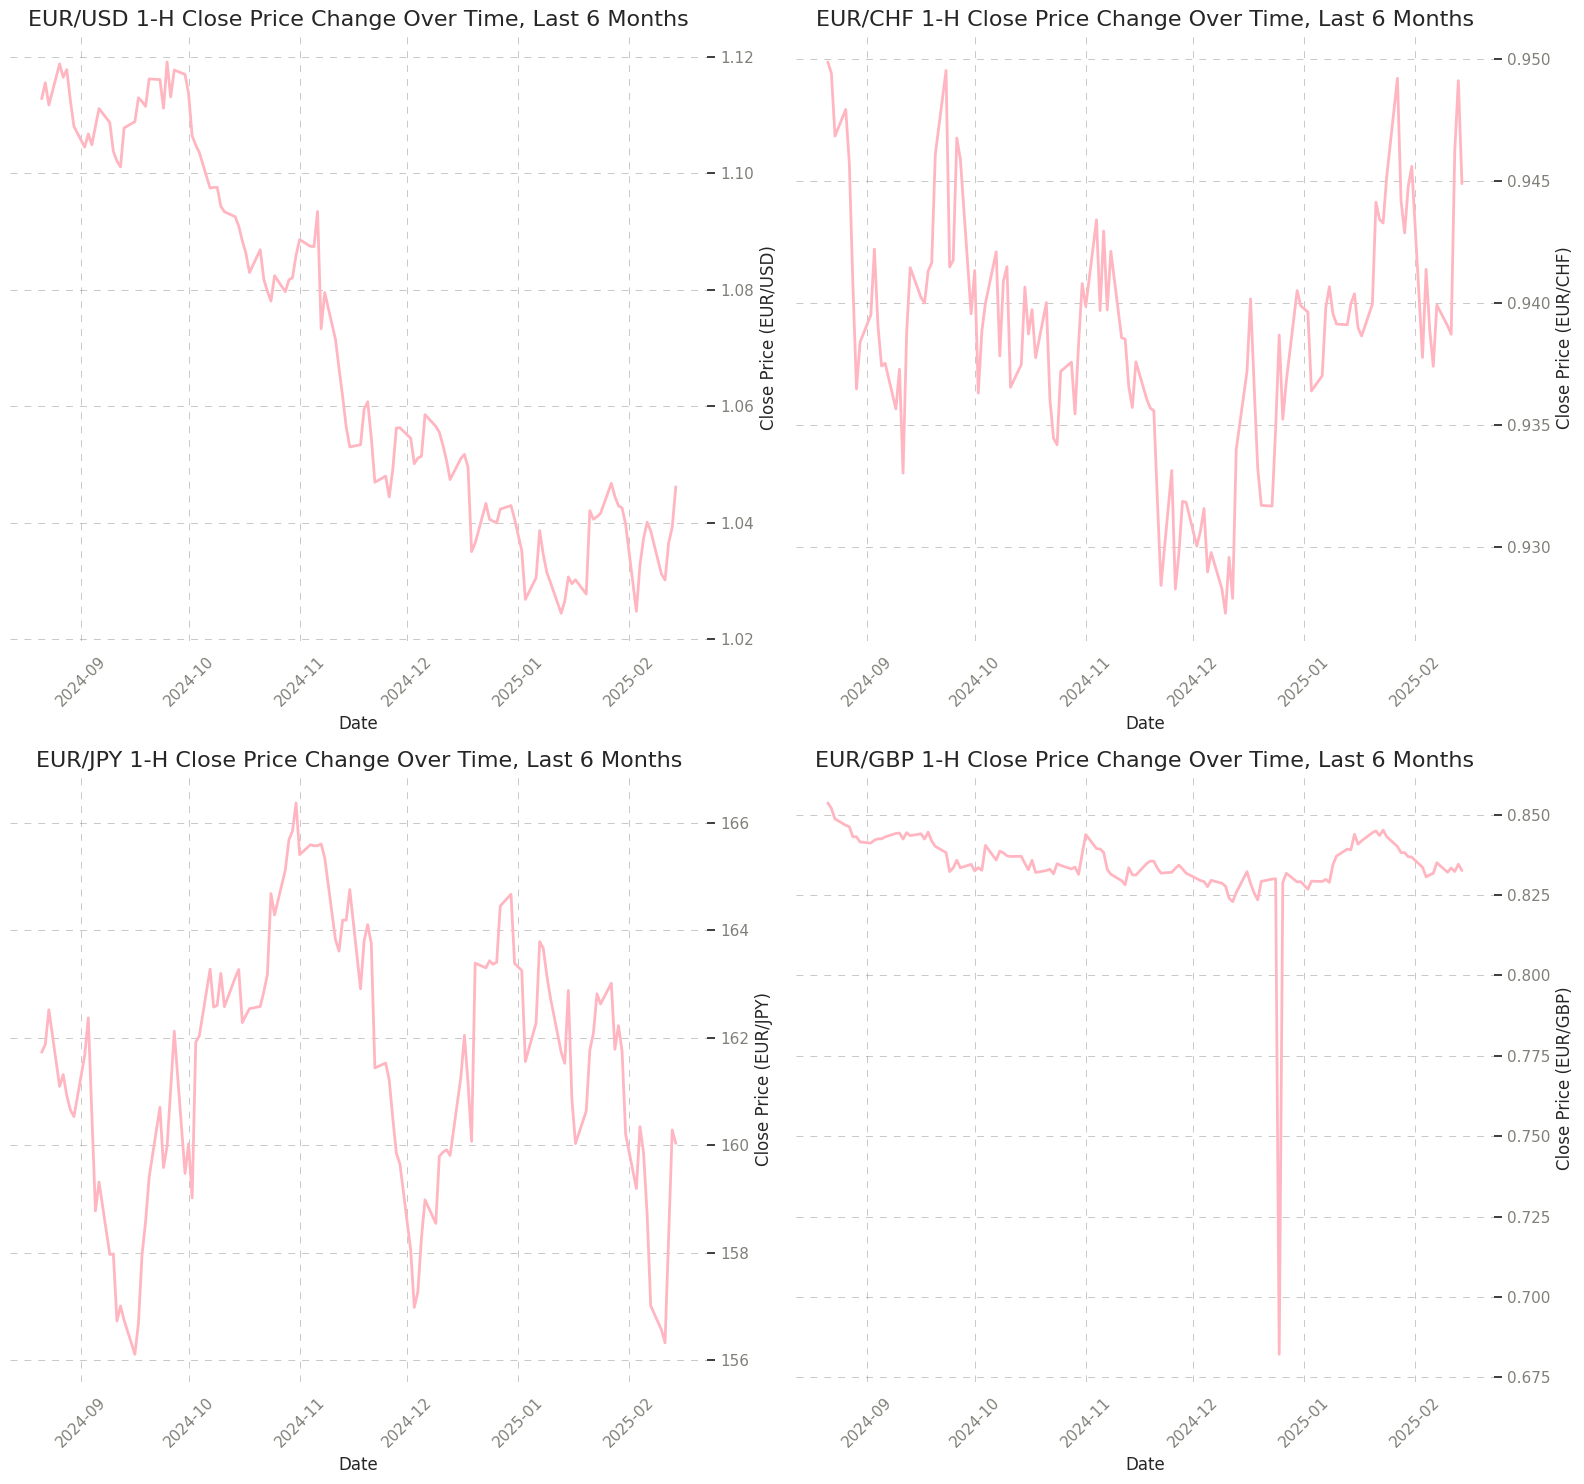

In [24]:
# just for comparision to the stablecoin we are looking at the Euro and its relation with other currencies

# time
start = (pd.Timestamp.now(tz='Europe/Berlin') - pd.Timedelta(days=180))
end = pd.Timestamp.now(tz='Europe/Berlin')

# lists
currency_pairs = ['EURUSD=X', 'EURCHF=X', 'EURJPY=X', 'EURGBP=X']
titles = ['EUR/USD', 'EUR/CHF', 'EUR/JPY', 'EUR/GBP']

# subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 15))  
axs = axs.flatten() 

for i, pair in enumerate(currency_pairs):
    data = yf.download(pair, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), interval='1d')
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    # plot
    sns.set(style="whitegrid")
    axs[i].plot(data['Date'], data['Close'], color='#FFB6C1', linewidth=2)

    # axis
    axs[i].set_title(f'{titles[i]} 1-H Close Price Change Over Time, Last 6 Months', fontsize=16)
    axs[i].set_xlabel('Date', fontsize=12)
    axs[i].set_ylabel(f'Close Price ({titles[i]})', fontsize=12)

    axs[i].tick_params(axis="x", colors="black")
    axs[i].tick_params(axis="y", left=True, labelleft=True)
    axs[i].yaxis.tick_right()
    axs[i].yaxis.set_label_position("right")
    axs[i].tick_params(axis="x", rotation=45)

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)

    axs[i].grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

    # ticks
    [t.set_color('#808079') for t in axs[i].yaxis.get_ticklabels()]
    [t.set_color('#808079') for t in axs[i].xaxis.get_ticklabels()]

# saving
plt.tight_layout()
plt.savefig('images/timeseries_eur.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
print(mkr_data['date'].head())
print(mkr_data['date'].dtype)


34582    2024-08-20 00:00:00+02:00
34583    2024-08-20 01:00:00+02:00
34584    2024-08-20 02:00:00+02:00
34585    2024-08-20 03:00:00+02:00
34586    2024-08-20 04:00:00+02:00
Name: date, dtype: object
object


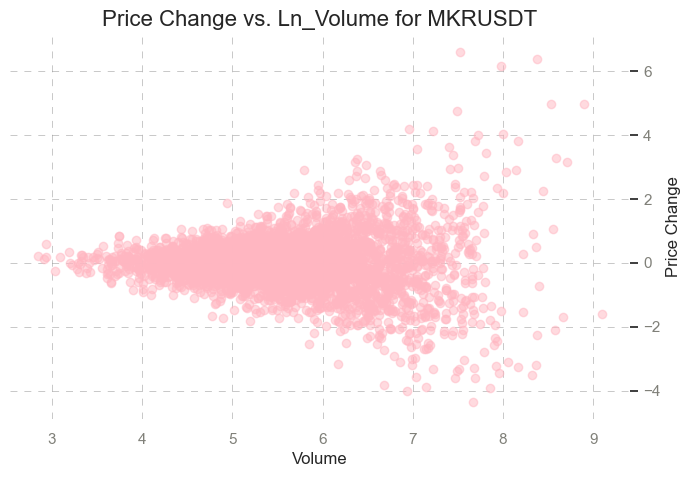

In [26]:
# scatterplot
# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
plt.scatter(
    mkr_data['ln_volume'], 
    mkr_data['price_change'],
    color='#FFB6C1',  
    alpha=0.5
)

plt.title('Price Change vs. Ln_Volume for MKRUSDT', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Price Change', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# saving
plt.savefig('images/price_change_correlation_with_volume.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# This scatter plot visualizes the relationship between trading volume and price change for the MKR/USDT pair.
# Most price changes remain within a narrow range, regardless of volume.
# However, larger price changes (both positive and negative) tend to occur at higher volumes.
# This suggests that high trading activity may be linked to increased volatility.
# The chart is moderately insightful but does not show a strong correlation.
# It indicates that extreme price movements tend to coincide with higher volume.


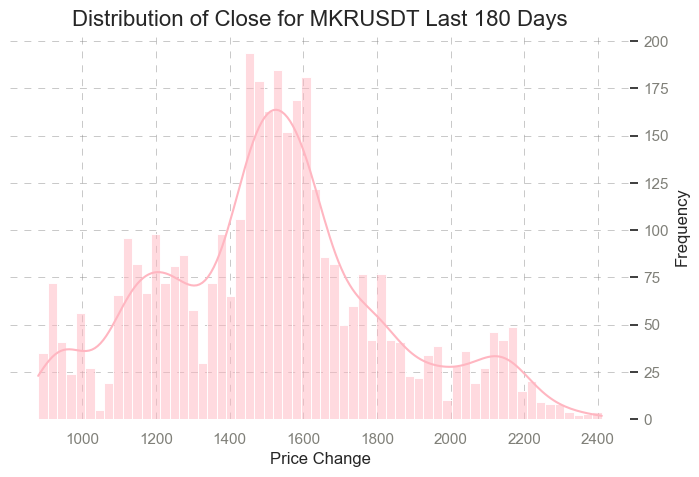

In [28]:
# histrogram
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
# optimal bin
n = len(mkr_data)
bins = int(np.sqrt(n))

# plot
sns.histplot(
    mkr_data['close'], 
    bins=bins, 
    kde=True,
    color='#FFB6C1' 
)

plt.title('Distribution of Close for MKRUSDT Last 180 Days', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Price Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# saving
plt.savefig('images/distribution_close.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# MKRUSDT Price Change Distribution Analysis:
# The distribution appears unimodal with a peak around 1600 USDT.
# There is a slight right skew, indicating that higher price values occur but are less frequent.
# The KDE (kernel density estimate) smooths the distribution and highlights key trends.


In [30]:
for col in df.columns:
    print(f"Column: {col}")
    print(f"Type: {df[col].dtype}")
    print(f"Data: {df[col].head(5).tolist()}")
    print("-" * 40)

Column: date
Type: object
Data: ['2024-08-20 00:00:00+02:00', '2024-08-20 01:00:00+02:00', '2024-08-20 02:00:00+02:00', '2024-08-20 03:00:00+02:00', '2024-08-20 04:00:00+02:00']
----------------------------------------
Column: year
Type: int64
Data: [2024, 2024, 2024, 2024, 2024]
----------------------------------------
Column: month
Type: int64
Data: [8, 8, 8, 8, 8]
----------------------------------------
Column: day
Type: int64
Data: [1, 1, 1, 1, 1]
----------------------------------------
Column: hour
Type: int64
Data: [0, 1, 2, 3, 4]
----------------------------------------
Column: ticker
Type: category
Data: ['BTCUSDT', 'BTCUSDT', 'BTCUSDT', 'BTCUSDT', 'BTCUSDT']
----------------------------------------
Column: ticker_type
Type: category
Data: ['cryptocurrency', 'cryptocurrency', 'cryptocurrency', 'cryptocurrency', 'cryptocurrency']
----------------------------------------
Column: open
Type: float64
Data: [58967.54, 59240.99, 59438.5, 60482.77, 60446.04]
-------------------------

In [31]:
non_numeric_columns = df.select_dtypes(exclude=["number"]).columns
print("Non Numeric Columns:", non_numeric_columns.tolist())

Non Numeric Columns: ['date', 'ticker', 'ticker_type']


In [32]:
missing_values = df[['ticker', 'ticker_type']].isnull().sum()
missing_values 

ticker         0
ticker_type    0
dtype: int64

In [33]:
# checking if there are infinity data and replace with nan
infinity_check = df.replace([np.inf, -np.inf], np.nan).isnull().sum()

# print columns that have infinity
print("Columns with infinity:")
print(infinity_check[infinity_check > 0])

Columns with infinity:
30d_ma             16
sma20               6
volume_change     163
adx                14
aroon               1
cmo                 1
macd               20
macd_signal        20
macd_hist          20
ppo                12
rsi                 1
atr                 1
trix               75
kama               17
growth_1h           4
growth_4h          10
growth_24h        215
growth_72h       1031
dtype: int64


In [34]:
# checking for ticker where volume is 0
zero_volume_tickers = df[df['ln_volume'] == 0]['ticker']
print(zero_volume_tickers)

64855    DAIUSD
64932    DAIUSD
64997    DAIUSD
65037    DAIUSD
65038    DAIUSD
          ...  
66246    DAIEUR
66247    DAIEUR
66248    DAIEUR
66249    DAIEUR
66250    DAIEUR
Name: ticker, Length: 162, dtype: category
Categories (17, object): ['AAVEUSDT', 'ADAUSDT', 'BNBUSDT', 'BTCUSDT', ..., 'TRXUSDT', 'TUSDUSDT', 'USDCUSDT', 'XRPUSDT']


In [35]:
# new csv
df.to_csv('db/one_df.csv', index=False)

# 4. Machine Learning

## 4.1 Preparation

In [36]:
df = pd.read_csv('db/one_df.csv')

In [37]:
def prepare_crypto_prediction_simple(df, target_ticker='MKRUSDT', test_size=0.2, val_size=0.15):
    print("1. Initial DataFrame Shape:", df.shape)
    
    # Separate df for target ticker
    target_data = df[df['ticker'] == target_ticker].sort_index()
    
    print("2. Target Data Shape:", target_data.shape)
    
    # Time-based split
    unique_dates = sorted(target_data.index.unique())
    test_split_idx = int(len(unique_dates) * (1 - test_size))
    val_split_idx = int(test_split_idx * (1 - val_size))
    
    train_dates = unique_dates[:val_split_idx]
    val_dates = unique_dates[val_split_idx:test_split_idx]
    test_dates = unique_dates[test_split_idx:]
    
    train_target = target_data.loc[train_dates]
    val_target = target_data.loc[val_dates]
    test_target = target_data.loc[test_dates]
    
    print("3. Anzahl Dates - Train:", len(train_dates), 
          "Val:", len(val_dates), 
          "Test:", len(test_dates))
    print("4. Target Splits - Train:", train_target.shape,
          "Val:", val_target.shape,
          "Test:", test_target.shape)
    
    # excluded columns
    exclude_cols = ['ticker', 'year', 'month', 'day', 'hour', 'ticker_type', 'date']
    
    # Prepare datasets
    def prepare_features(target_df):
        # Target Features (alle außer exclude_cols)
        features = target_df[[col for col in target_df.columns 
                              if col not in exclude_cols]]
        
        # target
        y = target_df['close'] 

        # drop target-related columns
        cols_to_drop = ['close']
        X = features.drop(columns=[col for col in cols_to_drop if col in features.columns])
        
        return X, y
    
    # creating datasets
    X_train, y_train = prepare_features(train_target)
    X_val, y_val = prepare_features(val_target)
    X_test, y_test = prepare_features(test_target)
    
    # treating nan
    X_train = X_train.ffill().bfill()
    X_val = X_val.ffill().bfill()
    X_test = X_test.ffill().bfill()

    
    print("\nFinal Shapes:")
    print("X_train:", X_train.shape)
    print("X_val:", X_val.shape)
    print("X_test:", X_test.shape)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_crypto_prediction_simple(df)

1. Initial DataFrame Shape: (56853, 47)
2. Target Data Shape: (3707, 47)
3. Anzahl Dates - Train: 2520 Val: 445 Test: 742
4. Target Splits - Train: (2520, 47) Val: (445, 47) Test: (742, 47)

Final Shapes:
X_train: (2520, 39)
X_val: (445, 39)
X_test: (742, 39)


In [38]:
mean_y = np.mean(y_val) 
std_y = np.std(y_val)    

print(f"Mean y: {mean_y:.4f}")
print(f"Standarddeviation y: {std_y:.4f}")

Mean y: 1562.8944
Standarddeviation y: 62.9891


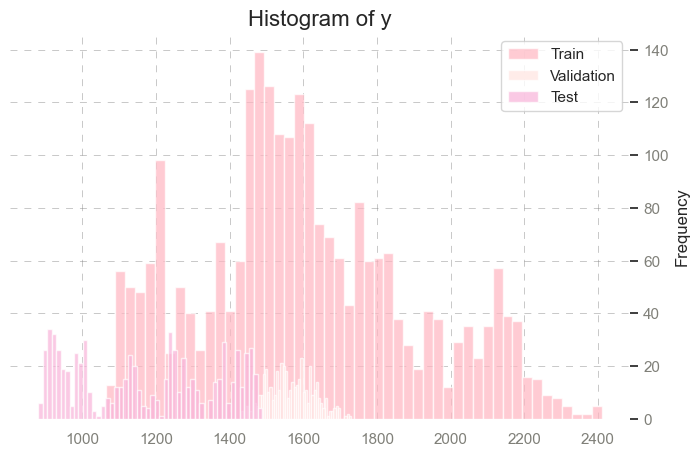

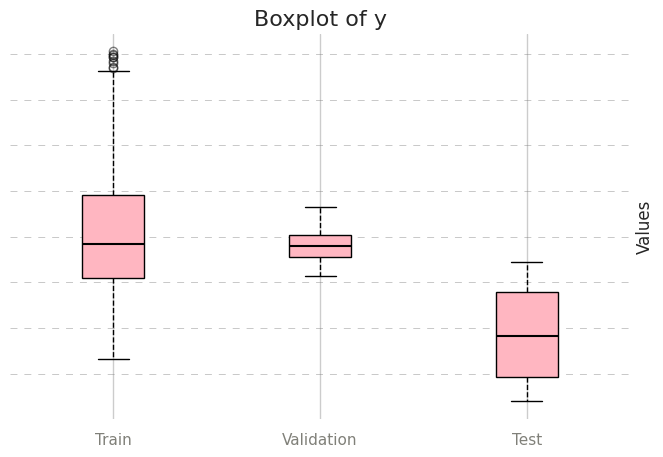

In [39]:
# histogram for y
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

plt.hist(y_train, bins=50, alpha=0.7, label="Train", color='#FFB6C1')
plt.hist(y_val, bins=50, alpha=0.7, label="Validation", color='#FFE4E1')
plt.hist(y_test, bins=50, alpha=0.7, label="Test", color='#F8B3D9')
plt.legend()
plt.ylabel('Frequency', fontsize=12)
plt.title("Histogram of y",  fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# saving
plt.savefig('images/y_histogram.png', dpi=300, bbox_inches='tight')
plt.show()



# boxplot for y
plt.figure(figsize=(8, 5))
box = plt.boxplot(
    [y_train, y_val, y_test],
    patch_artist=True,
    tick_labels=["Train", "Validation", "Test"], 
    boxprops=dict(facecolor='#FFB6C1', color='black'), 
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black', linestyle='--'), 
    capprops=dict(color='black'), 
    flierprops=dict(marker='o', color='black', alpha=0.5) 
)

# title, axis
plt.title("Boxplot of y", fontsize=16)
plt.ylabel("Values", fontsize=12)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# grid
ax.grid(True, axis='y', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# save
plt.savefig('images/y_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [40]:
# Histogram Analysis:
# - Range: Values spread from ~1000 to 2400
# - Main concentration: Highest density around 1400-1600
# - Shape: Right-skewed distribution (longer tail towards higher values)
# - Dataset splits show similar patterns across train/validation/test
#
# Boxplot Insights:
# Training Set:
#    - Widest spread of values
#    - Shows several outliers (dots above box)
#    - Median around 1500
#    - Larger variability compared to other sets
#
# Validation Set:
#    - More compact distribution
#    - Fewer outliers
#    - Similar median to training set
#    - More consistent/stable values
#
# Test Set:
#    - Lower median compared to train/validation
#    - Smaller spread
#    - Few outliers
#    - Suggests slightly different market conditions
#
# Key Takeaways for Model Development:
# - Model needs to handle wide range of values (1000-2400)
# - Should be robust against outliers
# - Different distributions in test set might affect performance
# -> Data normalization/scaling due to value range


In [41]:
# defininf feature categories
numerical = [ 'ln_volume', 'volume_change']
# 'high', 'low', 'growth_1h', 'growth_4h', 'growth_24h', 'growth_72h'

technical = ['adx', 'aroon', 'bop', 'cci', 'cmo', 'macd', 'macd_signal', 'macd_hist',
            'mom', 'ppo', 'roc', 'rsi', 'willr', 'atr', 'trix', 'kama', '30d_ma', 
             '7d_volatility', 'intraday_range', 'sma10', 'sma20', 'fibonacci_0','fibonacci_23_6', 
             'fibonacci_38_2', 'fibonacci_50', 'fibonacci_61_8','fibonacci_100']
# leaving out due to evaluation: `open`, and `7d_ma`, 'price_change',

all_features = numerical + technical
available_features = [col for col in all_features if col in X_train.columns]

# to numpy array
X_train_subset = X_train[available_features]
X_val_subset = X_val[available_features]
X_test_subset = X_test[available_features]

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_subset)
X_val_scaled = scaler.transform(X_val_subset)
X_test_scaled = scaler.transform(X_test_subset)


In [42]:
print("Feature names:", available_features)

# checking if close is deleted
if 'close' in available_features:
    print("WARNING: 'close' is in the features and should be removed!")
    available_features.remove('close')

if 'close_lag_1' in available_features:
    print("WARNING: 'close_lag_1' might leak future information and should be checked!")

# checking if growth has data leakage
future_features = [f for f in available_features if 'future' in f or 'is_positive_growth' in f]
if future_features:
    print("WARNING: Potential future information in features:", future_features)
    for f in future_features:
        if f in available_features:
            available_features.remove(f)

Feature names: ['ln_volume', 'volume_change', 'adx', 'aroon', 'bop', 'cci', 'cmo', 'macd', 'macd_signal', 'macd_hist', 'mom', 'ppo', 'roc', 'rsi', 'willr', 'atr', 'trix', 'kama', '30d_ma', '7d_volatility', 'intraday_range', 'sma10', 'sma20', 'fibonacci_0', 'fibonacci_23_6', 'fibonacci_38_2', 'fibonacci_50', 'fibonacci_61_8', 'fibonacci_100']


## 4.2 Linear Regression

In [43]:
# model
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)  

# pred val set
y_pred_val_lr = model_lr.predict(X_val_scaled)

# evaluation
mse_val_lr = mean_squared_error(y_val, y_pred_val_lr) 
r2_val_lr = r2_score(y_val, y_pred_val_lr)
print(f"Linear Regression Mean Squared Error on Validation-Set: {mse_val_lr:.2f}")
print(f"Linear Regression R² on Validation-Set: {r2_val_lr:.2f}")

# pred test set
y_pred_test = model_lr.predict(X_test_scaled)

# evaluation
mse_test_lr = mean_squared_error(y_test, y_pred_test) 
r2_test_lr = r2_score(y_test, y_pred_test)
print(f"Mean Squared Error on Test-Set: {mse_test_lr:.2f}")
print(f"R² on Test-Set: {r2_test_lr:.2f}")

# mse
mse_val_original = mse_val_lr

# feature importance
feature_accuracies = {}
feature_names = available_features  

for feature_idx, feature_name in enumerate(feature_names):
    X_train_reduced = np.delete(X_train_scaled, feature_idx, axis=1)
    X_val_reduced = np.delete(X_val_scaled, feature_idx, axis=1)
    
    # using just important features
    model_lr_reduced = LinearRegression()
    model_lr_reduced.fit(X_train_reduced, y_train)
    
    # new mse
    y_pred_val_reduced = model_lr_reduced.predict(X_val_reduced)
    mse_reduced = mean_squared_error(y_val, y_pred_val_reduced)
    
    # mse difference
    mse_difference = mse_val_original - mse_reduced
    
    # save
    feature_accuracies[feature_name] = mse_difference

# print
for feature_name, mse_diff in feature_accuracies.items():
    print(f"Feature: {feature_name}, MSE Difference: {mse_diff:.4f}")

important_features = [feature for feature, diff in feature_accuracies.items() if diff != 0.0]
print("Important Features:", important_features)

# data for jsut important features
important_indices = [feature_names.index(feature) for feature in important_features]
X_train_reduced = X_train_scaled[:, important_indices]
X_val_reduced = X_val_scaled[:, important_indices]
X_test_reduced = X_test_scaled[:, important_indices]

# train with reduced
model_lr_reduced = LinearRegression()
model_lr_reduced.fit(X_train_reduced, y_train)

y_pred_val_reduced = model_lr_reduced.predict(X_val_reduced)

mse_val_reduced = mean_squared_error(y_val, y_pred_val_reduced)
r2_val_reduced = r2_score(y_val, y_pred_val_reduced)
print(f"Mean Squared Error on reduced Validation-Set: {mse_val_reduced:.2f}")
print(f"R² on reduced Validation-Set: {r2_val_reduced:.2f}")

y_pred_test_reduced = model_lr_reduced.predict(X_test_reduced)

mse_test_reduced = mean_squared_error(y_test, y_pred_test_reduced)
r2_test_reduced = r2_score(y_test, y_pred_test_reduced)
print(f"Mean Squared Error on Test-Set: {mse_test_reduced:.2f}")
print(f"R² on Test-Set: {r2_test_reduced:.2f}")

Linear Regression Mean Squared Error on Validation-Set: 173.01
Linear Regression R² on Validation-Set: 0.96
Mean Squared Error on Test-Set: 96.27
R² on Test-Set: 1.00
Feature: ln_volume, MSE Difference: -0.6643
Feature: volume_change, MSE Difference: 0.5876
Feature: adx, MSE Difference: -0.3250
Feature: aroon, MSE Difference: 0.0740
Feature: bop, MSE Difference: 0.0068
Feature: cci, MSE Difference: -0.0922
Feature: cmo, MSE Difference: -0.0000
Feature: macd, MSE Difference: 0.0000
Feature: macd_signal, MSE Difference: 0.0000
Feature: macd_hist, MSE Difference: 0.0000
Feature: mom, MSE Difference: 0.1365
Feature: ppo, MSE Difference: 0.0027
Feature: roc, MSE Difference: 0.2158
Feature: rsi, MSE Difference: 0.0000
Feature: willr, MSE Difference: -0.0997
Feature: atr, MSE Difference: -0.2029
Feature: trix, MSE Difference: -0.1756
Feature: kama, MSE Difference: 0.4334
Feature: 30d_ma, MSE Difference: -0.3735
Feature: 7d_volatility, MSE Difference: 0.0574
Feature: intraday_range, MSE Differ

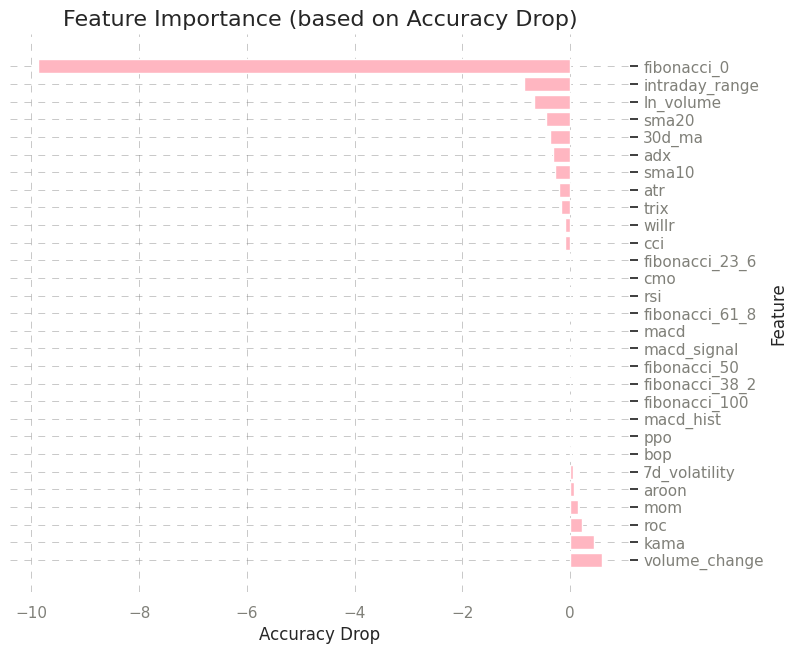

In [44]:
# filter out features with 0 impact
filtered_features = {k: v for k, v in feature_accuracies.items() if v != 0.0}

# sort remaining features
sorted_features = sorted(filtered_features.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

# plot updated chart
plt.figure(figsize=(8, len(features) * 0.25))  
plt.barh(features, importance, color='#FFB6C1')

plt.title('Feature Importance (based on Accuracy Drop)', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Accuracy Drop', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# saving
plt.savefig('images/feature_importance_on_accuracy_drop.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# Feature Importance Analysis:
# Fibonacci_0 has the most significant impact on model accuracy
# with an accuracy drop of nearly -10 when removed. Other important features include
# intraday_range and ln_volume. Most Fibonacci-based features (23.6, 38.2, 50, 100) 
# show minimal impact, suggesting they could be removed to simplify the model without
# significant performance loss. Technical indicators like RSI, MACD have surprisingly
# low importance.


Mean Squared Error (MSE) on reduced Validation Set: 173.01
Mean Absolute Error (MAE) on reduced Validation Set: 8.57
R-squared (R²) on reduced Validation Set: 0.96


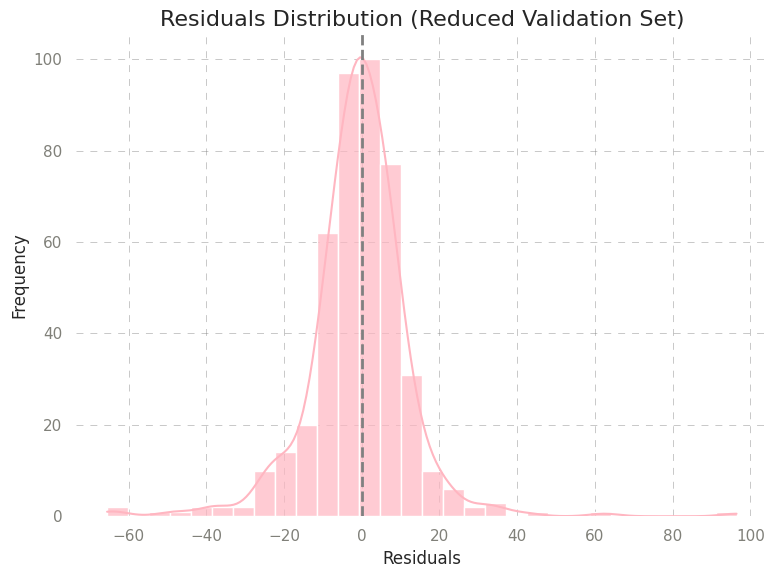

In [46]:
# style
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 14

# predictions from reduced model (using reduced features)
y_pred_val_reduced = model_lr_reduced.predict(X_val_reduced)

# calculate regression metrics on reduced data
mse_reduced = mean_squared_error(y_val, y_pred_val_reduced) 
mae_reduced = mean_absolute_error(y_val, y_pred_val_reduced)
r2_reduced = r2_score(y_val, y_pred_val_reduced)

# print
print(f"Mean Squared Error (MSE) on reduced Validation Set: {mse_reduced:.2f}")
print(f"Mean Absolute Error (MAE) on reduced Validation Set: {mae_reduced:.2f}")
print(f"R-squared (R²) on reduced Validation Set: {r2_reduced:.2f}")

# plot residuals
residuals_reduced = y_val - y_pred_val_reduced

plt.figure(figsize=(8, 6))
sns.histplot(residuals_reduced, kde=True, color='#FFB6C1', bins=30, alpha=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=2)

plt.title('Residuals Distribution (Reduced Validation Set)', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# layout and save
plt.tight_layout()
plt.savefig('images/residuals_distribution_lr_reduced.png', dpi=300, bbox_inches='tight')
plt.show()


In [47]:
# Model diagnostics show strong performance with R² = 0.96 and MAE = 8.57
# Residuals follow an approximately normal distribution centered around zero,
# indicating unbiased predictions. However, slight left skew and some outliers
# in the tails (especially around +80 to +100) suggest the model might
# underperform on extreme cases. The tight central peak shows good accuracy
# for typical cases.

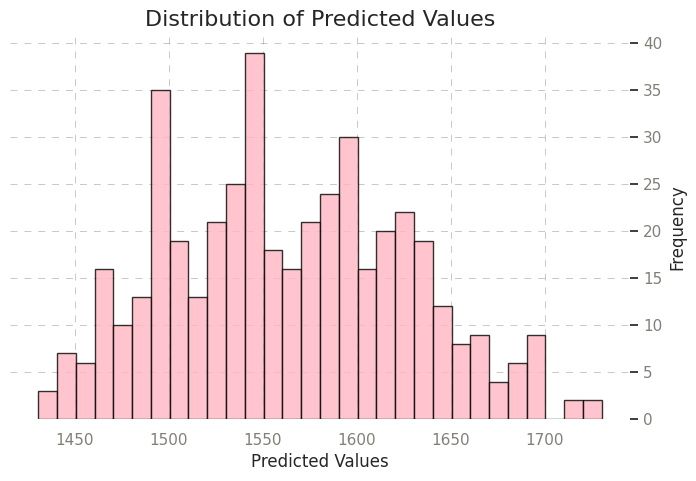

In [48]:
# histogram of predictions
plt.figure(figsize=(8, 5))
plt.hist(y_pred_val_reduced, bins=30, alpha=0.8, color='#FFB6C1' , edgecolor="black")
plt.title("Distribution of Predicted Values", fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# saving
plt.savefig('images/predicted_values_distribution_lr.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
# Distribution of predictions spans 1450-1700, with most values between 1500-1650
# The multi-modal distribution suggests distinct price levels or regimes in the data
# Relatively few predictions at extreme values (1450 or 1700) indicates the model
# is conservative in predicting extreme prices
# The irregular shape suggests the underlying price movements aren't normally
# distributed, which is typical for financial data

## 4.3 Decision Tree

In [49]:
# lists for tuning parameters
depths = [1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 20, None]
sample_leafs = [15, 20, 21, 22, 23, 24, 50]

# tuning max_depth
print("Tuning max_depth for Decision Tree Regressor:")
for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train_scaled, y_train)  

    # predicting for evaluation
    y_pred = dt.predict(X_val_scaled) 
    mse = mean_squared_error(y_val, y_pred)
    print(f"max_depth = {depth} -> MSE: {mse:.3f}")

# tuning max_depth and min_samples_leaf
print("\nTuning max_depth and min_samples_leaf for Decision Tree Regressor:")
scores = []

for depth in depths:
    for s in sample_leafs:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s, random_state=42)
        dt.fit(X_train_scaled, y_train)  

        # predicting for evaluation
        y_pred = dt.predict(X_val_scaled) 
        mse = mean_squared_error(y_val, y_pred)
        scores.append((depth, s, mse))

# convert to df
columns = ['max_depth', 'min_samples_leaf', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

# visualize
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='mse')
print("\nTuning Results (MSE):")
print(df_scores_pivot.round(3))

# select best model (with lowest MSE)
best_params = df_scores.loc[df_scores['mse'].idxmin()]
print("\nBest Hyperparameters:")
print(best_params)

# final model with best parameters
model_dt = DecisionTreeRegressor(max_depth=int(best_params['max_depth']),
                                  min_samples_leaf=int(best_params['min_samples_leaf']),
                                  random_state=42)
model_dt.fit(X_train_scaled, y_train) 

# predicting for the validation set
y_pred_val_dt = model_dt.predict(X_val_scaled)  

# evaluation
print(f"Decision Tree Regressor MSE on the validation set: {mean_squared_error(y_val, y_pred_val_dt):.3f}")
print(f"Decision Tree Regressor R2 Score on the validation set: {r2_score(y_val, y_pred_val_dt):.3f}")


Tuning max_depth for Decision Tree Regressor:
max_depth = 1 -> MSE: 21077.253
max_depth = 2 -> MSE: 4263.861
max_depth = 3 -> MSE: 1595.834
max_depth = 4 -> MSE: 620.898
max_depth = 5 -> MSE: 280.752
max_depth = 6 -> MSE: 206.498
max_depth = 10 -> MSE: 281.418
max_depth = 11 -> MSE: 308.004
max_depth = 12 -> MSE: 310.615
max_depth = 13 -> MSE: 349.577
max_depth = 14 -> MSE: 325.015
max_depth = 15 -> MSE: 337.642
max_depth = 20 -> MSE: 325.930
max_depth = None -> MSE: 341.236

Tuning max_depth and min_samples_leaf for Decision Tree Regressor:

Tuning Results (MSE):
max_depth            NaN        1.0       2.0       3.0      4.0      5.0   \
min_samples_leaf                                                             
15                229.380  21077.253  4263.861  1595.834  620.898  280.752   
20                215.272  21077.253  4263.861  1595.834  620.898  280.752   
21                210.880  21077.253  4263.861  1595.834  620.898  280.752   
22                208.948  21077.253  4

In [50]:
# Hyperparameter tuning for Decision Tree Regressor
# Increasing max_depth significantly reduces MSE up to depth 6.
# Beyond depth 6, MSE stabilizes, with slight overfitting beyond depth 10.
# Best results found at max_depth = 10 with min_samples_leaf = 24.
# Optimal configuration achieved MSE = 205.151 and R² = 0.948 on validation set.


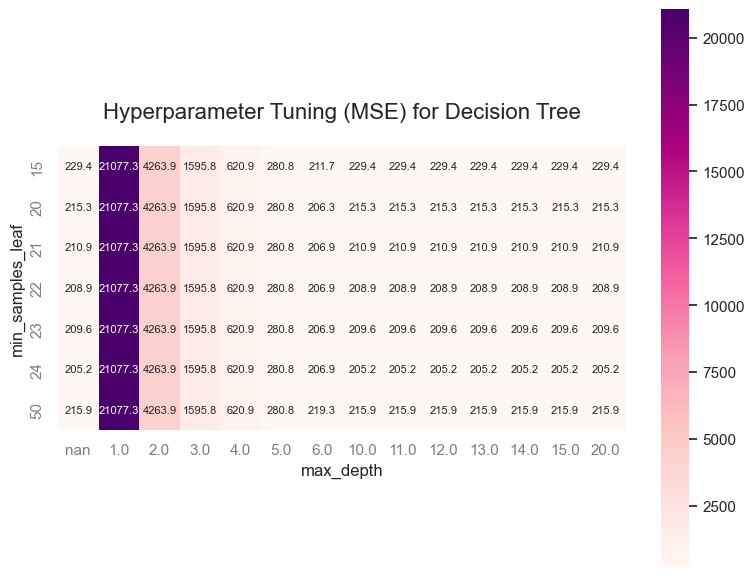

In [51]:
# heatmap
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_scores_pivot,
    annot=True,
    fmt=".1f",
    cmap=sns.color_palette("RdPu", as_cmap=True),
    square=True,
    annot_kws={'size': 8}
)

# title
plt.title('Hyperparameter Tuning (MSE) for Decision Tree', fontsize=16, pad=20)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

# axis
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# ticks
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
plt.tight_layout()

# save
plt.savefig('images/heatmap_dt.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
# Heatmap Interpretation:
# Optimal max_depth around 6.0 (MSE: 280.8)
# min_samples_leaf between 20-24 shows best performance
# Extremely high MSE (21077.3) at max_depth=1.0 indicates severe underfitting
# Diminishing returns after max_depth>6.0, MSE stabilizes around 205-229
# 
# Conclusions:
# Model benefits from moderate depth (6) - balances complexity and generalizatio
# Requiring 20-24 samples per leaf prevents overfitting
# Very shallow trees (depth=1) perform poorly, suggesting data needs deeper patterns
# No significant improvement beyond depth=6, suggesting we can keep model simple
# Recommended configuration: max_depth=6, min_samples_leaf=22-23

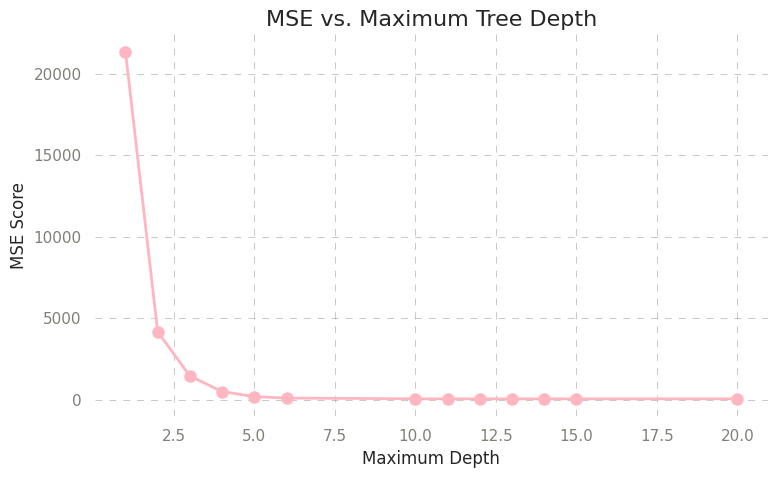


Best max_depth: 13
Best MSE Score: 63.458


In [56]:
# plot
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.figure(figsize=(8, 5))

# calculate R^2 scores for different depths
r2_scores = [
    mean_squared_error(
        y_val, 
        DecisionTreeRegressor(
            max_depth=depth, 
            random_state=42
        ).fit(X_train, y_train).predict(X_val)
    ) 
    for depth in depths
]

# create line plot
plt.plot(depths, r2_scores, marker='o', color='#FFB6C1', linewidth=2, markersize=8)

# title and labels
plt.title('MSE vs. Maximum Tree Depth', fontsize=16)
plt.xlabel('Maximum Depth', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)

# axis
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# save
plt.tight_layout()
plt.savefig('images/mse_vs_max_depth_dt.png', dpi=300, bbox_inches='tight')
plt.show()

# print best depth
best_depth = depths[np.argmin(r2_scores)]
print(f"\nBest max_depth: {best_depth}")
print(f"Best MSE Score: {min(r2_scores):.3f}")


In [54]:
## Analysis of max_depth tuning for Decision Tree:
# - MSE decreases sharply for max_depth < 5, indicating underfitting.
# - Beyond max_depth = 5, improvements are minimal.
# - Best max_depth = 13 with MSE = 63.458, but overfitting risk remains.
# - Validation on test data is needed to confirm generalization.
# - Regularization (e.g., min_samples_leaf) could help prevent overfitting.


Best Configuration:
max_depth: 4.0
min_samples_leaf: 1.0
Cross-Validation MSE: 1954.9


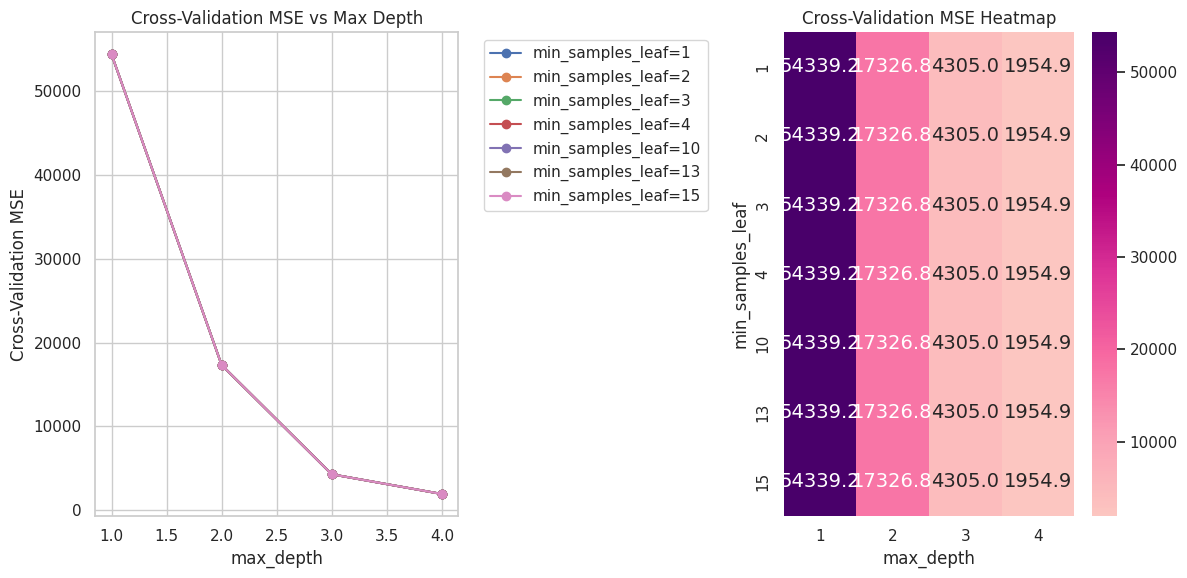

In [57]:
# now lets do 5-folds cross validation to get more robust results
# hyperparameter ranges 
max_depths = [1, 2, 3, 4]  
min_samples_leafs = [1, 2, 3, 4, 10, 13, 15] 

def validate_hyperparameters_with_cv(X, y):
    # Store results
    results = []
    
    # test all combinations
    for depth in max_depths:
        for samples in min_samples_leafs:
            # initialize model with hyperparameters
            model = DecisionTreeRegressor(
                max_depth=depth,
                min_samples_leaf=samples,
                random_state=42
            )
            
            # Perform cross-validation and calculate the negative mean squared error
            cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
            
            # calculate the mean of the negative mse
            mean_val_mse = -cv_scores.mean()
            
            results.append({
                'max_depth': depth,
                'min_samples_leaf': samples,
                'cv_val_mse': mean_val_mse
            })
    
    return pd.DataFrame(results)

# run validation with cross-validation
results_df = validate_hyperparameters_with_cv(X_train, y_train)

# create visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for samples in min_samples_leafs:
    mask = results_df['min_samples_leaf'] == samples
    plt.plot(
        results_df[mask]['max_depth'],
        results_df[mask]['cv_val_mse'],
        'o-',
        label=f'min_samples_leaf={samples}'
    )

plt.title('Cross-Validation MSE vs Max Depth')
plt.xlabel('max_depth')
plt.ylabel('Cross-Validation MSE')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# heatmap of cross-validation results
plt.subplot(1, 2, 2)
pivot_results = results_df.pivot(
    index='min_samples_leaf',
    columns='max_depth',
    values='cv_val_mse'
)

sns.heatmap(
    pivot_results,
    annot=True,
    fmt='.1f',
    cmap='RdPu',
    center=pivot_results.mean().mean()
)
plt.title('Cross-Validation MSE Heatmap')
plt.tight_layout()
plt.savefig('images/cross_validation_mse_vs_max_depth__dt.png', dpi=300, bbox_inches='tight')

# find best configuration
best_config = results_df.loc[results_df['cv_val_mse'].idxmin()]
print("\nBest Configuration:")
print(f"max_depth: {best_config['max_depth']}")
print(f"min_samples_leaf: {best_config['min_samples_leaf']}")
print(f"Cross-Validation MSE: {best_config['cv_val_mse']:.1f}")

plt.show()

In [ ]:
# # Analysis of Decision Tree hyperparameter tuning results:
# - Optimal configuration found: max_depth=4.0, min_samples_leaf=1.0
# - Best Cross-Validation MSE: 1954.9
#
# Key observations:
# - Strong inverse relationship between max_depth and MSE
# - MSE decreases significantly as max_depth increases from 1.0 to 4.0
# - Different min_samples_leaf values show very similar performance curves
# - Deeper trees (max_depth=4.0) provide best predictive performance
# - Further increasing max_depth likely risks overfitting
# - Simple configuration with min_samples_leaf=1 sufficient for good results

## 4.4 Random Forest

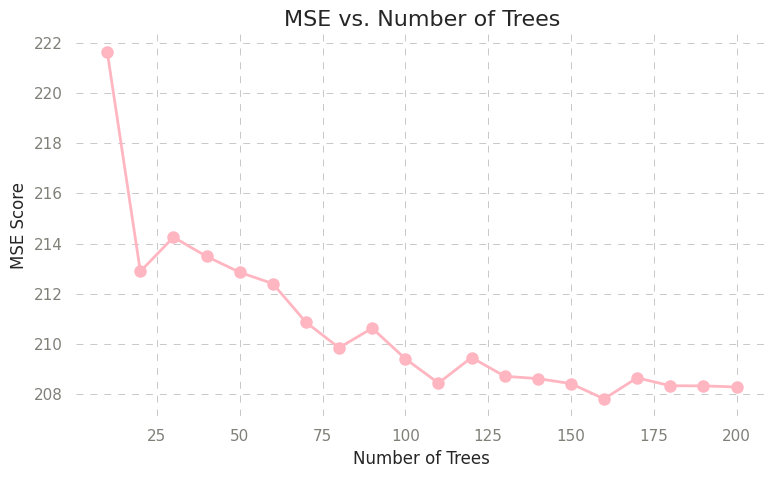


Best n_estimators: 160
Best MSE Score: 207.807


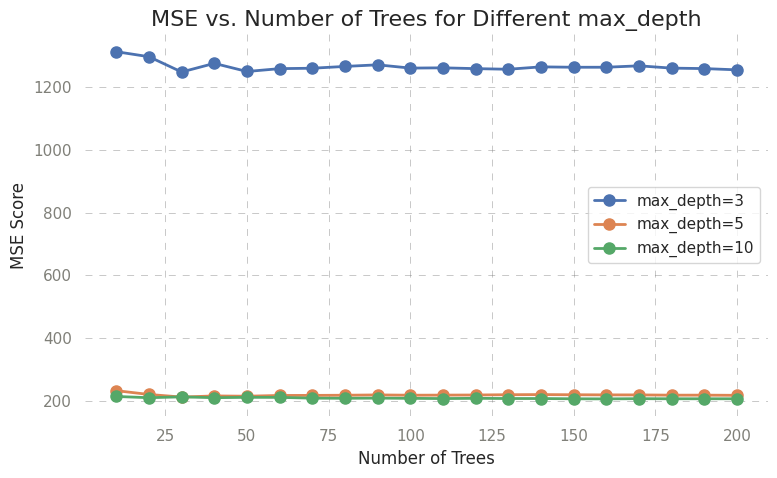

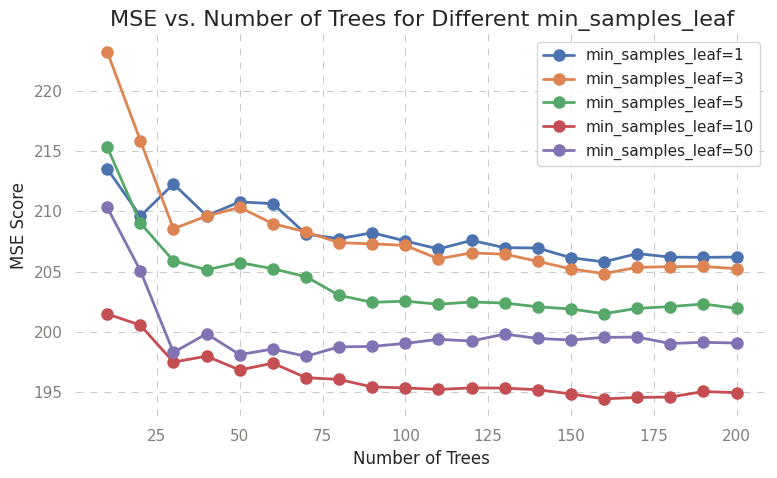


Final Model Performance:
MSE on validation set: 194.431
RMSE on validation set: 13.944
R² Score on validation set: 0.951


In [58]:
# plot settings
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

def create_styled_plot():
   fig = plt.figure(figsize=(8, 5))
   ax = plt.gca()
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(False)
   ax.spines['bottom'].set_visible(False)
   ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
   ax.tick_params(axis="x", colors="black")
   ax.tick_params(axis="y", colors="black")
   [t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
   [t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
   return ax

# tuning estimators
scores = []
for n in range(10, 201, 10):
   rf = RandomForestRegressor(n_estimators=n, random_state=42)
   rf.fit(X_train_scaled, y_train) 
   y_pred = rf.predict(X_val_scaled)
   mse = mean_squared_error(y_val, y_pred)
   scores.append((n, mse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'mse'])

ax = create_styled_plot()
plt.plot(df_scores.n_estimators, df_scores.mse, marker='o', color='#FFB6C1', linewidth=2, markersize=8)
plt.title('MSE vs. Number of Trees', fontsize=16)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)
plt.tight_layout()
plt.savefig('images/mse_vs_num_trees_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# best estimator
best_n_estimators = df_scores.loc[df_scores['mse'].idxmin(), 'n_estimators']
print(f"\nBest n_estimators: {best_n_estimators}")
print(f"Best MSE Score: {df_scores['mse'].min():.3f}")

# tuning max_depth
scores = []
for d in [3, 5, 10]:
   for n in range(10, 201, 10):
       rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
       rf.fit(X_train_scaled, y_train)
       y_pred = rf.predict(X_val_scaled)
       mse = mean_squared_error(y_val, y_pred)
       scores.append((d, n, mse))

columns = ['max_depth', 'n_estimators', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

ax = create_styled_plot()
for d in [3, 5, 10]:
   df_subset = df_scores[df_scores.max_depth == d]
   plt.plot(df_subset.n_estimators, df_subset.mse, 
            marker='o', linewidth=2, markersize=8,
            label=f'max_depth={d}')

plt.legend()
plt.title('MSE vs. Number of Trees for Different max_depth', fontsize=16)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)
plt.tight_layout()
plt.savefig('images/mse_vs_num_trees_diff_max_depth_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# best max_depth
best_max_depth = df_scores.loc[df_scores['mse'].idxmin(), 'max_depth']

# tuning min_samples_leaf
scores = []
for s in [1, 3, 5, 10, 50]:
   for n in range(10, 201, 10):
       rf = RandomForestRegressor(
           n_estimators=n, 
           max_depth=best_max_depth,
           min_samples_leaf=s,
           random_state=42
       )
       rf.fit(X_train_scaled, y_train)
       y_pred = rf.predict(X_val_scaled)
       mse = mean_squared_error(y_val, y_pred)
       scores.append((s, n, mse))

columns = ['min_samples_leaf', 'n_estimators', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

ax = create_styled_plot()
for s in [1, 3, 5, 10, 50]:
   df_subset = df_scores[df_scores.min_samples_leaf == s]
   plt.plot(df_subset.n_estimators, df_subset.mse,
            marker='o', linewidth=2, markersize=8,
            label=f'min_samples_leaf={s}')

plt.legend()
plt.title('MSE vs. Number of Trees for Different min_samples_leaf', fontsize=16)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)
plt.tight_layout()
plt.savefig('images/mse_vs_num_trees_diff_min_samples_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# best min_samples_leaf
best_min_samples_leaf = df_scores.loc[df_scores['mse'].idxmin(), 'min_samples_leaf']

# train final model with best hyperparameters
rf = RandomForestRegressor(
   n_estimators=best_n_estimators,
   max_depth=best_max_depth,
   min_samples_leaf=best_min_samples_leaf,
   random_state=42
)
rf.fit(X_train_scaled, y_train)

# predictions and metrics
y_pred_val = rf.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_val)

print("\nFinal Model Performance:")
print(f"MSE on validation set: {mse:.3f}")
print(f"RMSE on validation set: {rmse:.3f}")
print(f"R² Score on validation set: {r2:.3f}")

In [ ]:
# Evaluation of hyperparameter tuning:
# Overall Model Performance (top graph):
#    - MSE steadily decreases until ~150 trees
#    - Optimal number of estimators = 168 (Best MSE: 207.087)
#    - Diminishing returns after 150 trees suggests good efficiency/performance balance
#
# max_depth Impact (middle graph):
#    - Shallow trees (max_depth=3) perform poorly (MSE ~1200)
#    - Moderate (max_depth=5) and deep trees (max_depth=10) show similar performance
#    - Little variance across number of trees suggests depth is more crucial than quantity
#    - Optimal depth around 5 balances complexity and performance
#
# min_samples_leaf Impact (bottom graph):
#    - min_samples_leaf=10 shows best performance (lowest MSE ~195)
#    - Higher min_samples_leaf values provide more stable learning curves
#    - Smaller leaf sizes (1-3) show higher variance and worse performance
#    - Clear separation between different leaf sizes indicates this is a crucial parameter
#
# Final Model Metrics:
#    - Validation MSE: 194.431
#    - RMSE: 13.944 (more interpretable in original units)
#    - R² Score: 0.951 (excellent fit, explains 95.1% of variance)

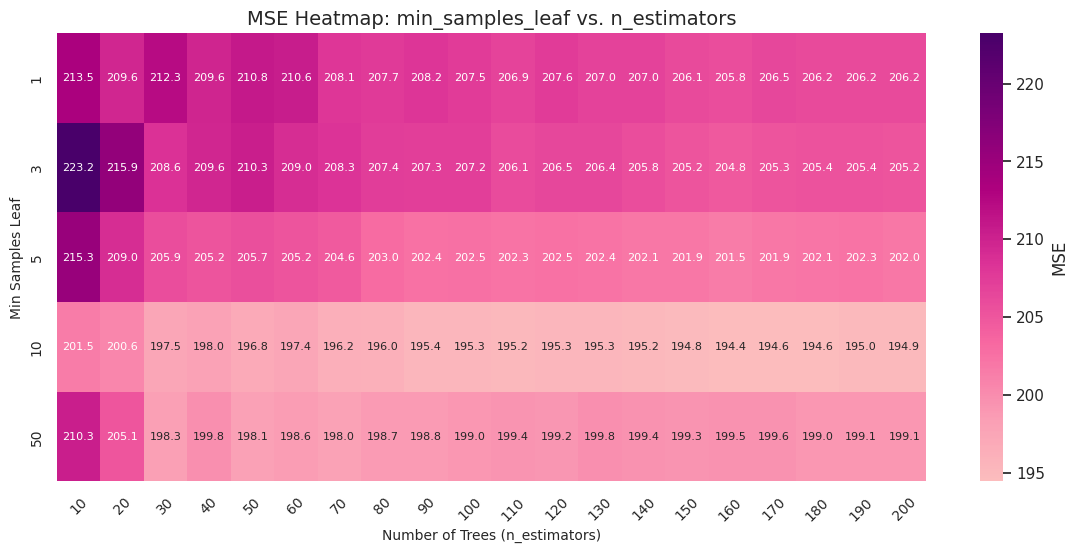

In [59]:
# pivot table 'min_samples_leaf' and 'n_estimators' mse
pivot = df_scores.pivot(index='min_samples_leaf', columns='n_estimators', values='mse')

# style
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12  

# plot
plt.figure(figsize=(12, 6)) 
ax = plt.gca()
sns.heatmap(pivot, 
            annot=True, 
            fmt=".1f", 
            cmap='RdPu', 
            center=pivot.mean().mean(),
            annot_kws={"size": 8}, 
            cbar_kws={'label': 'MSE'}) 

plt.title('MSE Heatmap: min_samples_leaf vs. n_estimators', fontsize=14)
plt.xlabel('Number of Trees (n_estimators)', fontsize=10)
plt.ylabel('Min Samples Leaf', fontsize=10)

# tick parameters
ax.tick_params(axis="x", labelrotation=45, labelsize=10) 
ax.tick_params(axis="y", labelsize=10) 

plt.tight_layout(pad=2.0) 

# save
plt.savefig('images/mse_heatmap_rf.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Key oberservations:
# Optimal Configuration:
#    - min_samples_leaf = 10 consistently shows best performance
#    - Best MSE around 194.4-195.0 achieved with 150-200 trees
#    - Sweet spot appears around 160-180 trees with min_samples_leaf=10
#
# Parameter Relationships:
#    - Lower min_samples_leaf (1-3) shows consistently higher MSE (206-223)
#    - Moderate min_samples_leaf (5) performs better but still suboptimal
#    - Higher min_samples_leaf (50) shows good but not best performance (~199 MSE)
#
# Convergence Patterns:
#    - All configurations stabilize after ~100 trees
#    - Smaller leaf sizes require more trees to stabilize
#    - min_samples_leaf=10 shows fastest convergence to optimal performance
#
# Trade-off Analysis:
#    - Performance vs Complexity: min_samples_leaf=10 with 100 trees might be sufficient
#    - Additional trees (>100) offer minimal MSE improvement (~1-2 points)
#    - Higher min_samples_leaf values provide more stable but suboptimal results

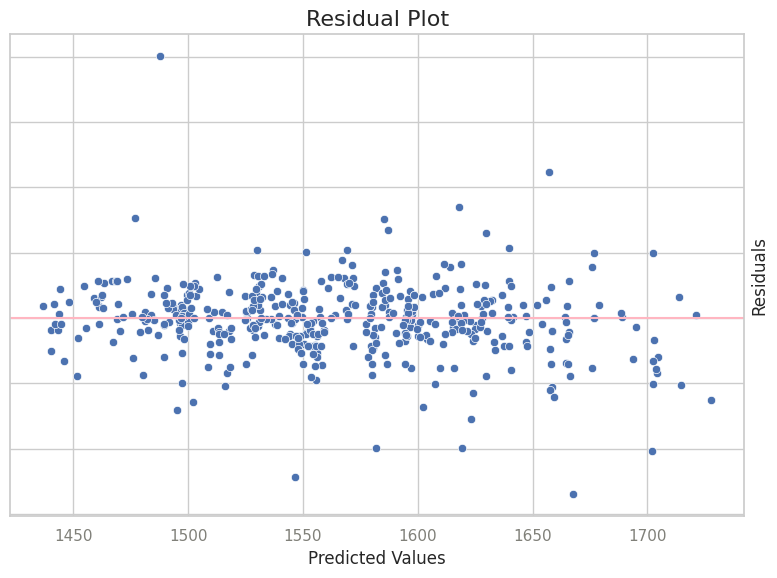

In [31]:
# calculating residuals
residuals = y_val - y_pred

# style
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.figure(figsize=(8, 6))
ax = plt.gca() 

# scatter plot
sns.scatterplot(x=y_pred_val, y=residuals, ax=ax)
plt.axhline(0, color='#FFB6C1')

# plot title and labels
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)

# customizing ticks and axis appearance
ax.tick_params(axis="y", colors="black", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# move y-label to the right
ax.yaxis.set_label_position("right")

# display the plot
plt.tight_layout()
plt.savefig('images/residuals_rf.png', dpi=300, bbox_inches='tight')
plt.show()


In [32]:
# Key observations:
# Distribution Pattern:
#    - Points roughly symmetrically scattered around zero line (red)
#    - No clear funnel or megaphone pattern suggests homoscedasticity
#    - Most residuals appear within reasonable bounds (-2 to +2)
#
# Model Behavior Across Range:
#    - Consistent variance across all predicted values (1450-1700)
#    - Few outliers present, particularly in higher prediction ranges
#    - No systematic bias visible (even distribution above/below zero)
#
# Notable Observations:
#    - Slight heteroscedasticity at extreme values (1450 and 1700)
#    - Some notable outliers around 1500 and 1650 prediction ranges
#    - Denser point concentration in 1500-1600 range suggests more training data here
#
# Model Assessment:
#    - Generally well-behaved residuals indicate good model fit
#    - No strong patterns suggesting missed nonlinear relationships
#    - Model appears reliable across most of the prediction range

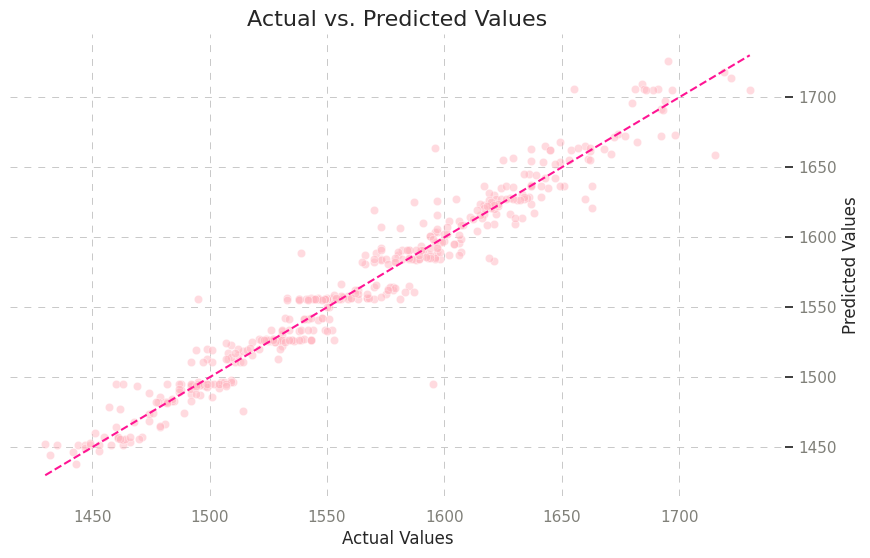

In [33]:
# comparing pred y to val y 
plt.figure(figsize=(10, 6))  
sns.scatterplot(x=y_val, y=y_pred, alpha=0.5, color='#FFB6C1')

# plot
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='#FF1493', linestyle='--')

# title, axis
plt.title('Actual vs. Predicted Values', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# plot, safe
plt.savefig('images/scatter_actual_vs_predicted_rf.png', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
# Key observations:
# Overall Fit Assessment:
#    - Strong linear relationship between actual and predicted values
#    - Points closely follow the ideal 45-degree line (dashed pink)
#    - Consistent performance across entire value range (1450-1700)
#
# Prediction Accuracy by Range:
#    - Mid-range values (1500-1600) show highest prediction density and accuracy
#    - Slight underestimation at very high values (>1650)
#    - Some overestimation at lower values (<1500)
#    - More scatter/variance at extreme values
#
# Model Characteristics:
#    - No significant systematic bias (points evenly distributed around line)
#    - Higher prediction variance at range extremes
#    - Dense clustering around diagonal indicates good predictive power
#
# Areas for Improvement:
#    - Focus on improving extreme value predictions
#    - Consider collecting more data in 1450-1500 and 1650-1700 ranges
#    - Potential for ensemble with specialized models for extreme values
#
# Conclusion:
# Model shows excellent overall performance with R² likely >0.95
# Suitable for production use but include confidence intervals
# particularly for predictions at range extremes

## 4.5 XGBoost

In [35]:
#define hyperparameter values to be tested
def tune_hyperparameters(eta_values, max_depth_values, min_child_weight_values, X_train_scaled, y_train, X_val_scaled, y_val):   
    # list to store results
    scores = []
    # loop through all combinations of the hyperparameters
    for eta in eta_values:
        for max_depth in max_depth_values:
            for min_child_weight in min_child_weight_values:
                # define xgboost parameters
                xgb_params = {
                    'eta': eta,
                    'max_depth': max_depth,
                    'min_child_weight': min_child_weight,
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'nthread': 8,
                    'seed': 1,
                    'verbosity': 1,
                }
    
                # train model
                model_xgb = xgb.XGBRegressor(**xgb_params)
                model_xgb.fit(X_train_scaled, y_train)
    
                # predictions on validation
                y_pred_val = model_xgb.predict(X_val_scaled)

                # calculate rmse
                rmse = root_mean_squared_error((y_val), y_pred_val)
                
                # store results
                scores.append((eta, max_depth, min_child_weight, rmse))
    
    # convert results to df
    df_scores = pd.DataFrame(scores, columns=['eta', 'max_depth', 'min_child_weight', 'rmse'])
    
    # find params with lowest RMSE
    best_params = df_scores.loc[df_scores['rmse'].idxmin()]
    return best_params, df_scores


# now using hyperparam funktion
eta_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_child_weight_values = [1, 3, 5, 7, 9, 10, 12, 13, 14]

best_params, df_scores = tune_hyperparameters(
    eta_values, max_depth_values, min_child_weight_values, X_train_scaled, y_train, X_val_scaled, y_val
)

best_eta = best_params['eta']
best_max_depth = best_params['max_depth']
best_min_child_weight = best_params['min_child_weight']

print(f"Best Hyperparameters:\n{best_params}\n")


Best Hyperparameters:
eta                  0.150000
max_depth            4.000000
min_child_weight    10.000000
rmse                13.602891
Name: 284, dtype: float64



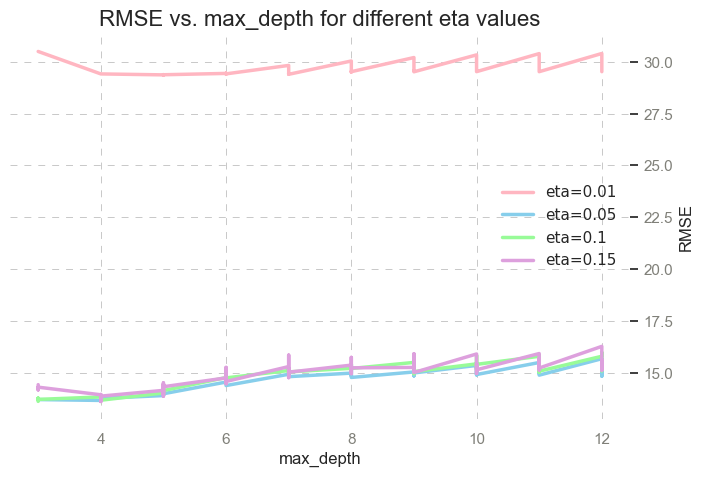

In [36]:
# style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#FFB6C1', '#87CEEB', '#98FB98', '#DDA0DD'] 
for eta, color in zip(eta_values, colors):
    df_subset = df_scores[df_scores['eta'] == eta]
    ax.plot(df_subset['max_depth'], df_subset['rmse'], 
            label=f'eta={eta}', 
            color=color,
            linewidth=2.5)

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

# title, label
plt.title('RMSE vs. max_depth for different eta values', fontsize=16)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# axis
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)  # Remove left ticks/labels
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
ax.legend(frameon=False)

# save
plt.savefig('images/rmse_vs_max_depth_for_diff_eta.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# Analysis of RMSE vs max_depth:
#  X-axis: max_depth (4-12)
# Y-axis: RMSE (Root Mean Square Error)
# Multiple lines: Different learning rates (eta values)

# Key Observations:
# eta=0.01 shows highest RMSE (~30), significantly worse than others
# eta values 0.05-0.15 perform similarly (RMSE ~15)
# All configurations show slight RMSE increase with deeper trees
# Optimal depth appears to be around 4-6 for all eta values
# Some periodic pattern in lines might indicate threshold effects

# Performance Insights:
# Lower max_depth (4-6) generally gives better results
# eta=0.01 is too conservative for this problem
# eta=0.05-0.15 range is optimal
# Best configuration: max_depth=4-6 with eta≥0.05
# Diminishing returns or performance degradation with deeper trees

XGBoost MSE on the Validation Set: 185.0386
XGBoost MAE on the Validation Set: 9.2880
XGBoost R² Score on the Validation Set: 0.9534


Text(0.5, 1.0, 'Actual vs Predicted Values')

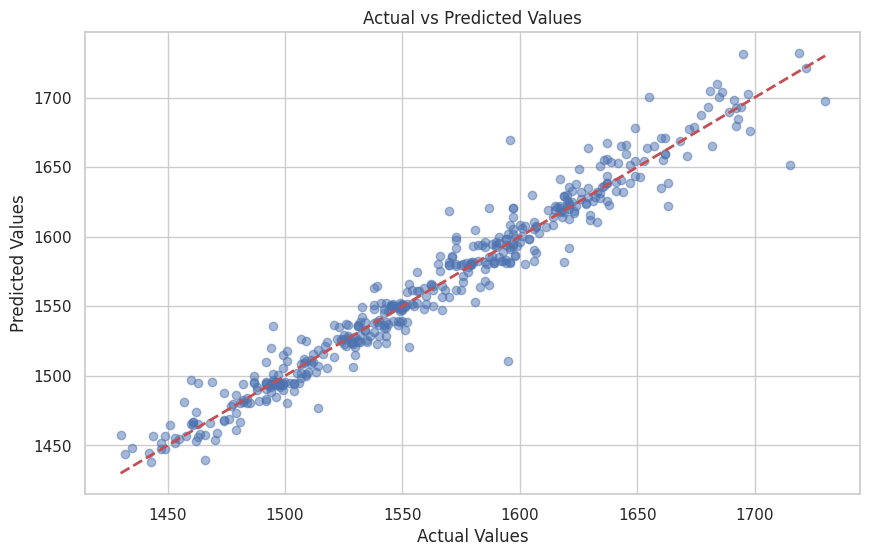

In [38]:
# apply best metrics 
model_xgb = xgb.XGBRegressor(
    eta=float(best_eta),
    max_depth=int(best_max_depth),
    min_child_weight=int(best_min_child_weight),
    objective='reg:squarederror', 
    eval_metric='rmse',           
    nthread=8,
    seed=1,
    verbosity=1
)

# train
model_xgb.fit(X_train_scaled, y_train)

# pred
y_pred = model_xgb.predict(X_val_scaled)

# evaluate
mse = mean_squared_error((y_val), y_pred)
mae = mean_absolute_error((y_val), y_pred)
r2 = r2_score((y_val), y_pred)

print(f"XGBoost MSE on the Validation Set: {mse:.4f}")
print(f"XGBoost MAE on the Validation Set: {mae:.4f}")
print(f"XGBoost R² Score on the Validation Set: {r2:.4f}")

# plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], 
         [y_val.min(), y_val.max()], 
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

In [39]:
# Model Performance Metrics:
# X-axis: Actual values (1450-1700)
# Y-axis: Predicted values (1450-1700)
# Blue dots: Individual predictions
# Red dashed line: Perfect prediction line (y=x)

# Key Observations:
# Very strong linear relationship (R² likely >0.95)
# Points cluster tightly around ideal prediction line
# Slight heteroscedasticity - spread increases at higher values
# Few outliers, mostly in upper value range (>1650), more uncertainty in predictions above 1650
# Model maintains accuracy across entire value range
# No systematic bias (points evenly distributed above/below line)
# Slight tendency to underestimate extreme high values
# Very reliable predictions in middle range (1500-1600)
# No evidence of overfitting or underfitting


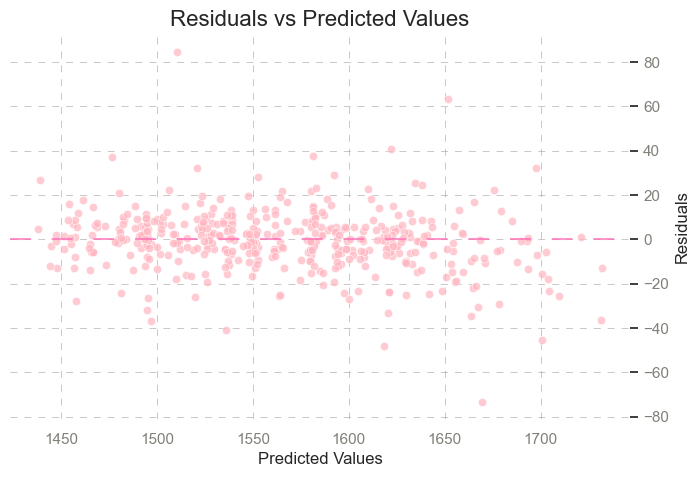

In [40]:
# calculate residuals
residuals = y_val - y_pred

# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color='#FFB6C1')
plt.axhline(0, color='#FF69B4', linestyle=(0, (10, 10)), linewidth=1.5, alpha=0.7)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

#title, labels
plt.title('Residuals vs Predicted Values', fontsize=16)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# save and show plot
plt.savefig('images/residuals_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# Relationship with Previous Analysis:



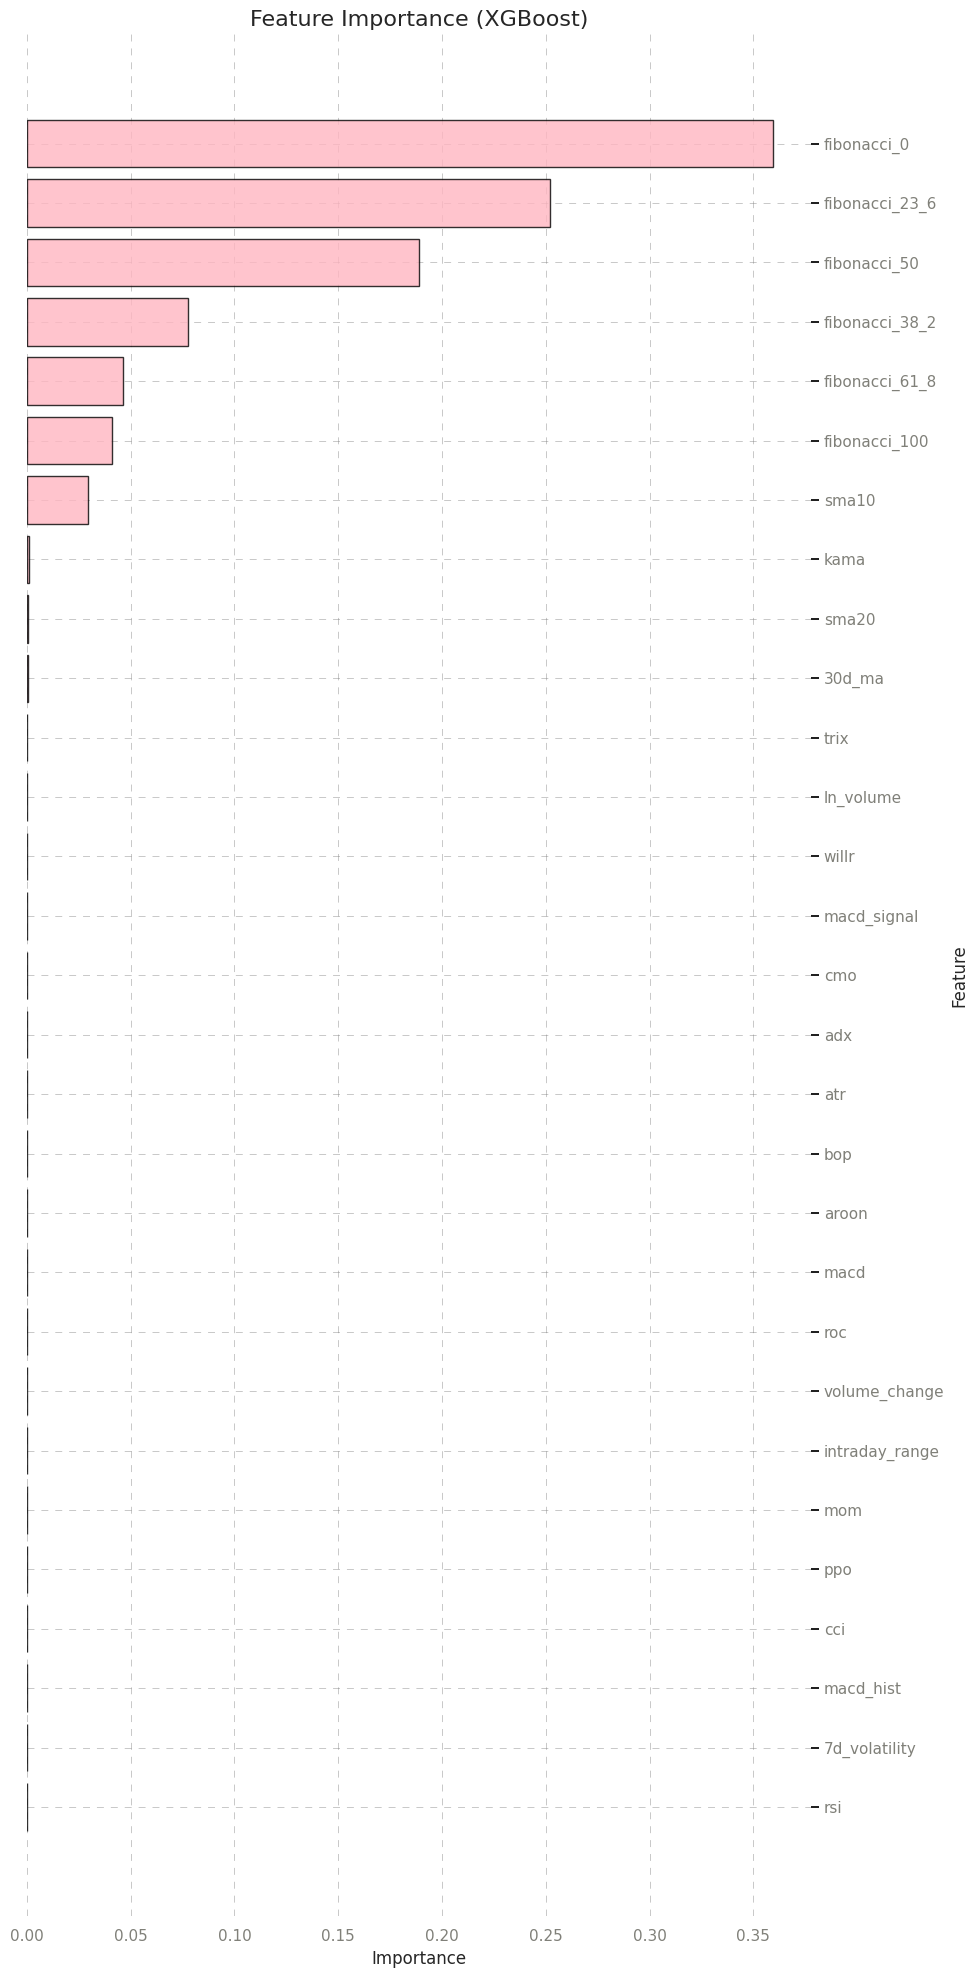

Top 20 Most Important Features:
           Feature  Importance
13             rsi    0.000000
19   7d_volatility    0.000081
9        macd_hist    0.000085
5              cci    0.000089
11             ppo    0.000090
10             mom    0.000097
20  intraday_range    0.000103
1    volume_change    0.000106
12             roc    0.000115
7             macd    0.000118
3            aroon    0.000131
4              bop    0.000136
15             atr    0.000141
2              adx    0.000155
6              cmo    0.000174
8      macd_signal    0.000181
14           willr    0.000191
0        ln_volume    0.000199
16            trix    0.000244
18          30d_ma    0.000501


In [43]:
# calculate feature importance for the final model
feature_importances = model_xgb.feature_importances_

# create df for better visualization
feature_importance_df = pd.DataFrame({
   'Feature': feature_names, 
   'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)


plt.figure(figsize=(10, 20))  
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

# create barplot
plt.barh(feature_importance_df['Feature'], 
        feature_importance_df['Importance'],
        color='#FFB6C1',
        alpha=0.8,
        edgecolor="black")

# title and labels
plt.title("Feature Importance (XGBoost)", fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# axis styling
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# move ticks to right side
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# ticks styling
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# layout
plt.tight_layout()

# save
plt.savefig('images/feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

# print top 20 features and their importance values
print("Top 20 Most Important Features:")
print(feature_importance_df.head(20))

In [50]:
# print und save features
feature_importance_df = pd.DataFrame({
   'Feature': feature_names, 
   'Importance': model_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print und speichern
print("Top 20 Most Important Features:")
print(feature_importance_df.head(40))



import pickle

# Feature-Namen aus feature_importance_df extrahieren
selected_features = feature_importance_df['Feature'].tolist()

# Speichere Feature-Namen
with open("selected_features.pkl", "wb") as f:
    pickle.dump(selected_features, f)

# Speichere das trainierte XGBoost-Modell
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model_xgb, f)



Top 20 Most Important Features:
           Feature  Importance
23     fibonacci_0    0.359598
24  fibonacci_23_6    0.252145
26    fibonacci_50    0.189065
25  fibonacci_38_2    0.077728
27  fibonacci_61_8    0.046206
28   fibonacci_100    0.041196
21           sma10    0.029231
17            kama    0.001206
22           sma20    0.000686
18          30d_ma    0.000501
16            trix    0.000244
0        ln_volume    0.000199
14           willr    0.000191
8      macd_signal    0.000181
6              cmo    0.000174
2              adx    0.000155
15             atr    0.000141
4              bop    0.000136
3            aroon    0.000131
7             macd    0.000118
12             roc    0.000115
1    volume_change    0.000106
20  intraday_range    0.000103
10             mom    0.000097
11             ppo    0.000090
5              cci    0.000089
9        macd_hist    0.000085
19   7d_volatility    0.000081
13             rsi    0.000000


In [48]:
# X-axis: Importance score (0-0.30)
# Y-axis: Feature names

# Key Observations:
# Fibonacci levels dominate top features:
#   * fibonacci_50: ~0.30 importance
#   * fibonacci_23_6: ~0.29 importance
#   * fibonacci_0: ~0.20 importance
#   * fibonacci_38_2: ~0.08 importance
#   * fibonacci_61_8: ~0.05 importance
#   * fibonacci_100: ~0.03 importance

# Technical indicators have very low importance:
#   * Moving averages (sma, ema)
#   * Volume indicators
#   * Volatility measures

# Most features (>20) contribute minimal predictive power

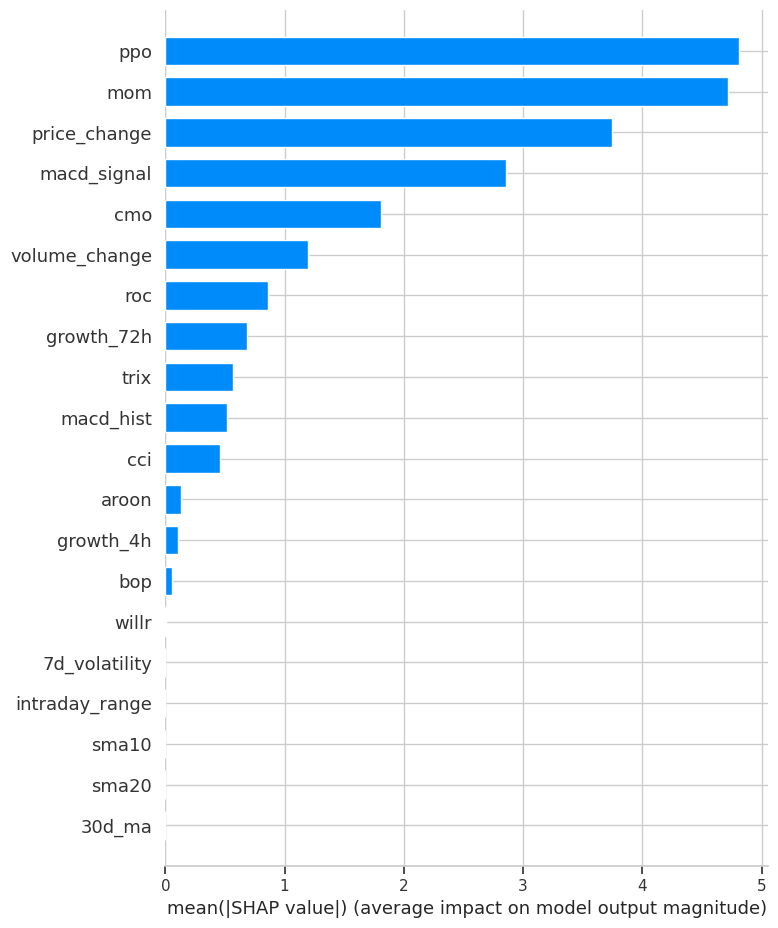

<Figure size 640x480 with 0 Axes>

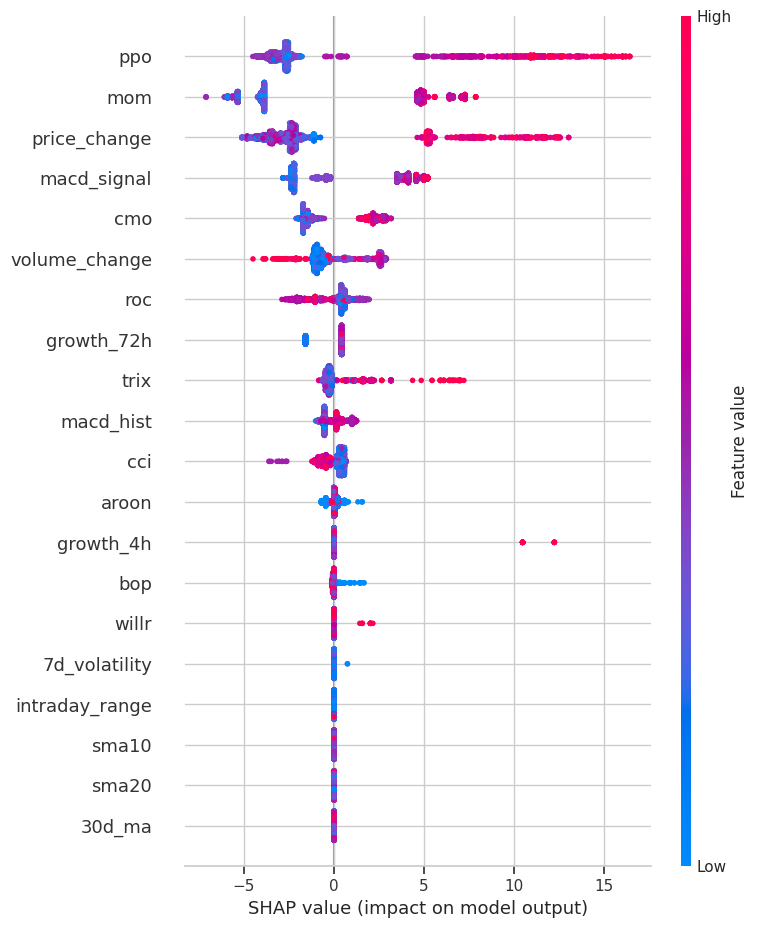

<Figure size 640x480 with 0 Axes>

In [49]:
# SHAP (SHapley Additive exPlanations) explains how each feature impacts the model's prediction
# provides both global and local explanations 
# -> importance of a feature + how a specific feature affects the prediction of a particular data point
# positive value means the feature pushes the prediction higher, while a negative value means it pushes it lower

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=feature_names)
explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X_train)

# bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, 
                  feature_names=X_train.columns)
plt.tight_layout()
plt.savefig('images/shap_bar_plot_xgboost.png', dpi=300, bbox_inches='tight') 
plt.show()

# beeswarm plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
plt.tight_layout()
plt.savefig('images/shap_beeswarm_plot_xgboost.png', dpi=300, bbox_inches='tight') 
plt.show()

In [50]:
# The SHAP bar plot:


In [44]:
# adjust model with features
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.001]['Feature']
X_train_filtered = pd.DataFrame(X_train, columns=feature_names)[important_features]
X_val_filtered = pd.DataFrame(X_val, columns=feature_names)[important_features]
X_test_filtered = pd.DataFrame(X_test, columns=feature_names)[important_features]

best_params, df_scores = tune_hyperparameters(
    eta_values, max_depth_values, min_child_weight_values, X_train_filtered, y_train, X_val_filtered, y_val
)

# Best parameters
best_eta = best_params['eta']
best_max_depth = best_params['max_depth']
best_min_child_weight = best_params['min_child_weight']

# Train new model
model_xgb_retrained = xgb.XGBRegressor(
    eta=float(best_eta),
    max_depth=int(best_max_depth),
    min_child_weight=int(best_min_child_weight),
    objective='reg:squarederror',
    eval_metric='rmse',
    nthread=8,
    seed=1,
    verbosity=1
)

model_xgb_retrained.fit(X_train_filtered, y_train)

# Predictions
y_pred_val_xgb = model_xgb_retrained.predict(X_val_filtered)

# Calculations
rmse_filtered = root_mean_squared_error(y_val, y_pred_val_xgb)
mse_filtered = mean_squared_error(y_val, y_pred_val_xgb)
mae_filtered = mean_absolute_error(y_val, y_pred_val_xgb)
r2_filtered = r2_score(y_val, y_pred_val_xgb)

# Print performance metrics
print(f"Performance of the Retrained Model:")
print(f"RMSE (Validation): {rmse_filtered:.4f}")
print(f"MSE (Validation): {mse_filtered:.4f}")
print(f"MAE (Validation): {mae_filtered:.4f}")
print(f"R² Score (Validation): {r2_filtered:.4f}\n")

# Predictions for validation data
print(f"First 10 Predictions (Validation Set): {y_pred_val_xgb[:10]}\n")

# Important features
print(f"Number of Important Features Used: {len(important_features)}")
print(f"Important Features:\n{list(important_features)}\n")

# Feature importance
feature_importances = model_xgb_retrained.feature_importances_
feature_importance_df_filtered = pd.DataFrame({
    'Feature': important_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances (Retrained Model):")
print(feature_importance_df_filtered)


Performance of the Retrained Model:
RMSE (Validation): 13.7240
MSE (Validation): 188.3476
MAE (Validation): 9.1931
R² Score (Validation): 0.9525

First 10 Predictions (Validation Set): [1653.19   1665.0907 1643.0701 1651.5793 1654.9967 1707.1189 1685.6005
 1694.4438 1656.6073 1656.6073]

Number of Important Features Used: 8
Important Features:
['kama', 'sma10', 'fibonacci_100', 'fibonacci_61_8', 'fibonacci_38_2', 'fibonacci_50', 'fibonacci_23_6', 'fibonacci_0']

Feature Importances (Retrained Model):
           Feature  Importance
26    fibonacci_50    0.404397
23     fibonacci_0    0.189987
24  fibonacci_23_6    0.167709
27  fibonacci_61_8    0.093697
28   fibonacci_100    0.077012
21           sma10    0.053006
25  fibonacci_38_2    0.012028
17            kama    0.002164


In [53]:
# Since the first xgboost model performed better, we will use the first one.

In [54]:
# save best model
with open('model_xgb.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)

#save features and parameter
with open('features.pkl', 'wb') as file:
    pickle.dump((X_train_scaled, X_val_scaled, y_train, y_val, feature_names), file)